In [1]:
import os
import colorsys
import numpy as np
import random
import pandas as pd
from scipy import stats
from collections import defaultdict

from scipy.spatial import cKDTree

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import py3Dmol

from Bio.PDB import PDBIO, PDBParser, Select
from Bio.PDB.Chain import Chain
from Bio.PDB.Residue import Residue

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances

## This notebook focuses on analysis of PocketMiner predictions for Spike protein structures to explore the validity of these outputs

In [2]:
# dictionary to convert residue names to single letter
three_to_one_leter_name = {
                           "GLY": "G",
                           "ALA": "A",
                           "VAL": "V",
                           "LEU": "L",
                           "ILE": "I",
                           "SER": "S",
                           "THR": "T",
                           "MET": "M",
                           "CYS": "C",
                           "ASN": "N",
                           "GLN": "Q",
                           "ASP": "D",
                           "GLU": "E",
                           "LYS": "K",
                           "ARG": "R",
                           "HIS": "H", "HSD": "H", "HSE": "H", "HSP": "H",
                           "PHE": "F",
                           "TRP": "W",
                           "TYR": "Y",
                           "PRO": "P",
                           }

# read Spike sequence to compare
Spike_protein = ''
with open('S_protein.fasta', 'r') as f:
    for line in f:
        if not line.startswith('>'):
            Spike_protein += line.strip()
            
# convert into dictionary
Spike_protein_residues = {i+1:Spike_protein[i] for i in range(len(Spike_protein))}

In [3]:
# list of the files for analysis
pdb_dirs = [x for x in os.listdir('.')]

files = []
for pdb_dir in pdb_dirs:
    if (not '.' in pdb_dir) and ('_' in pdb_dir):
        row = [pdb_dir, pdb_dir.split('_')[0].lower()]
        files.append(row)
files

[['7DDD_locked', '7ddd'],
 ['7K4N_up', '7k4n'],
 ['7KNI_up', '7kni'],
 ['6VXX_closed', '6vxx'],
 ['6ZP0_closed', '6zp0'],
 ['7KJ4_up', '7kj4'],
 ['6ZB5_locked', '6zb5'],
 ['7KSG_up', '7ksg'],
 ['7A98_up', '7a98'],
 ['6X29_closed', '6x29'],
 ['6ZGE_locked', '6zge'],
 ['6XR8_locked', '6xr8'],
 ['6X6P_closed', '6x6p'],
 ['6X2C_closed', '6x2c'],
 ['6ZB4_locked', '6zb4']]

In [4]:
# manually sort them
files = [
 ['7K4N_up', '7k4n'],
 ['7KNI_up', '7kni'],
 ['7KJ4_up', '7kj4'],
 ['7KSG_up', '7ksg'],
 ['7A98_up', '7a98'],
    
 ['6VXX_closed', '6vxx'],
 ['6ZP0_closed', '6zp0'],
 ['6X29_closed', '6x29'],
 ['6X6P_closed', '6x6p'],
 ['6X2C_closed', '6x2c'],
    
 ['6ZB5_locked', '6zb5'],
 ['6ZGE_locked', '6zge'],
 ['6XR8_locked', '6xr8'],
 ['6ZB4_locked', '6zb4'],
 ['7DDD_locked', '7ddd']
]

**Reload PM and fpocket data**

In [5]:
# reload matrices
PocketMiner_df = pd.read_csv('data/PocketMiner_data.csv', index_col=0)
pocket_contact_df = pd.read_csv('data/fpocket_contact_data.csv', index_col=0)
pocket_contact_df = pocket_contact_df.loc[:, :].astype(int)
pocket_volume_df = pd.read_csv('data/fpocket_volume_data.csv', index_col=0)

PocketMiner_df.head()

14   15   16   17   18   19   20   21   22   23  ...  1153  1154  \
7K4N_up_A -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ...  -1.0  -1.0   
7K4N_up_B -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ...  -1.0  -1.0   
7K4N_up_E -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ...  -1.0  -1.0   
7KNI_up_A -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ...  -1.0  -1.0   
7KNI_up_B -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ...  -1.0  -1.0   

           1155  1156  1157  1158  1159  1160  1161  1162  
7K4N_up_A  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  
7K4N_up_B  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  
7K4N_up_E  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  
7KNI_up_A  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  
7KNI_up_B  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  

[5 rows x 1149 columns]

<AxesSubplot:>

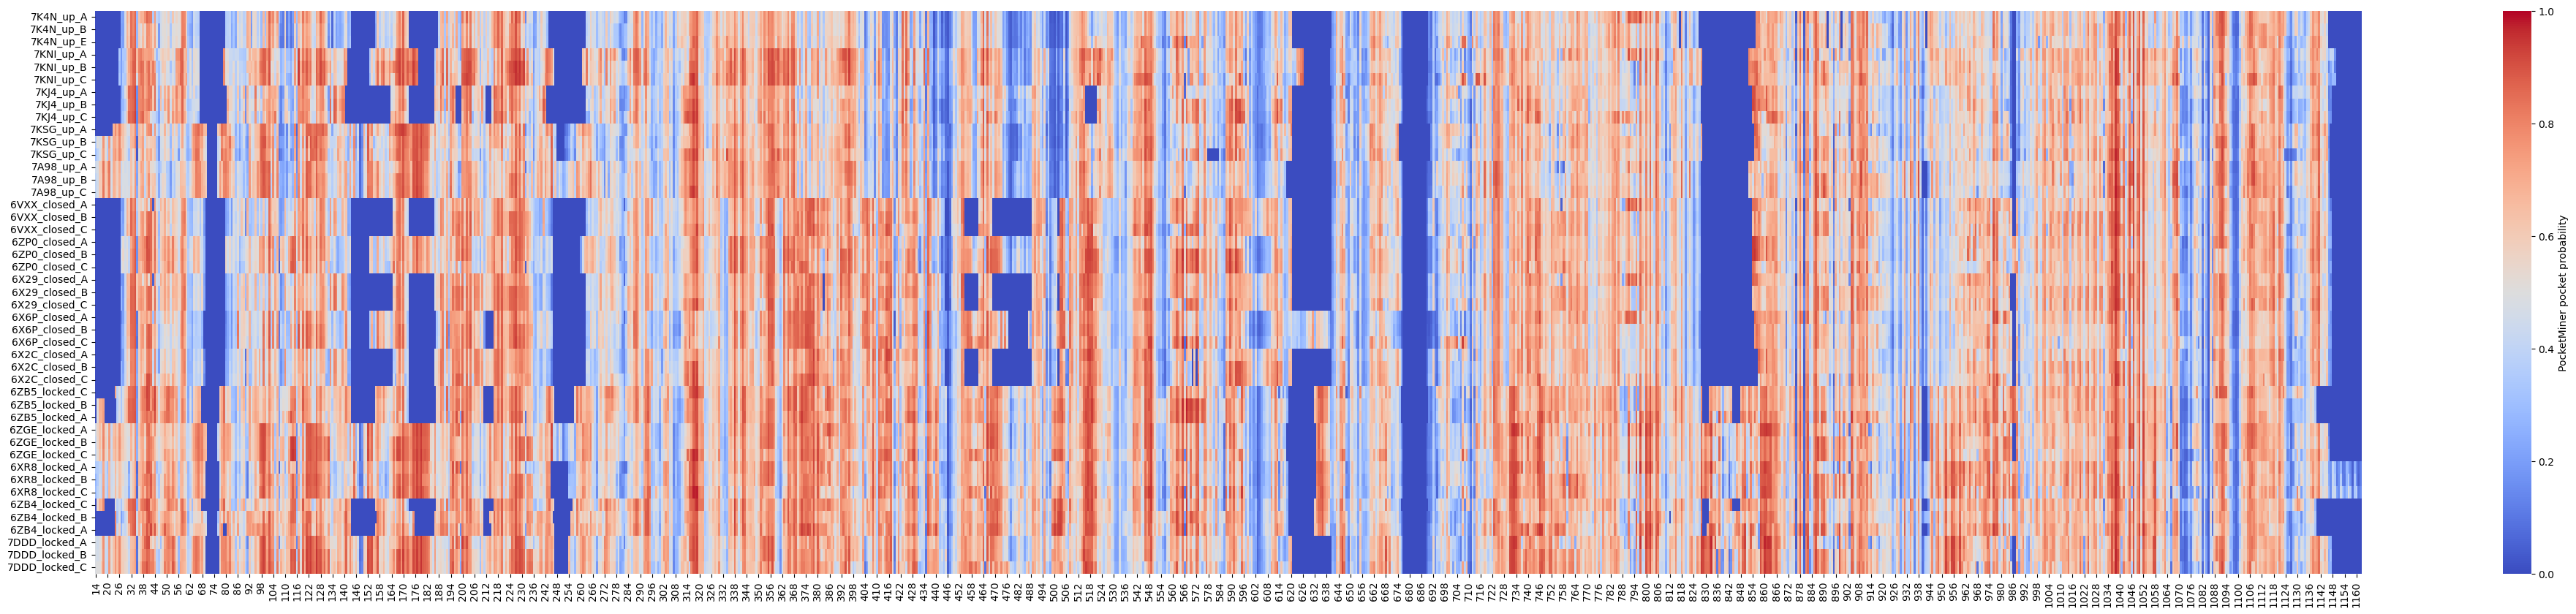

In [6]:
# quickly visualise the Pocket Miner matrix
plt.figure(figsize=(50, 10))
sns.heatmap(PocketMiner_df,
            vmin=0, vmax=1,
            cmap='coolwarm',
            cbar_kws={'label': 'PocketMiner pocket probability'})

In [8]:
# functions supporting various plots

def ResidueHeatMap(data, res_list, ref_prot_seq,
                   annotate_from=None, size=(30, 20)):
    
    x_lab = [f"{res[1]}_{res[0]}" for res in res_list]
    y_lab = PocketMiner_df.index.values
    
    col_mask = [str(res[0]) for res in res_list]
    
    plt.figure(figsize=size)
    sns.set(font_scale=1)
    
    # set boundaries
    if data.max().max() > 1:
        min_val, max_val = 0, data.max().max()
        pallete = 'flare'
        annot_format = "g"
    else:
        min_val, max_val = 0, 1
        pallete = 'coolwarm'
        annot_format = ".2"
    
    # define annotation
    if annotate_from is None:
        annotation = data.loc[:, col_mask]
        cbar_label = 'PocketMiner pocket probability'
    else:
        annotation = annotate_from.loc[:, col_mask]
        cbar_label = 'Pocket volume'
    
    # construct the heatmap
    ax = sns.heatmap(data.loc[:, col_mask],
                    vmin=min_val, vmax=max_val,
                    cmap=pallete,
                    annot = annotation,
                    fmt=annot_format,
                    xticklabels=x_lab, 
                    yticklabels=y_lab,
                    cbar_kws={'label': cbar_label})
    
    # draw lines to separate structures
    ax.hlines([i for i in range(3,45,3)], *ax.get_xlim(),
              linewidths=3, color='#044004')
    
    # draw lines to separate structure classes
    ax.hlines([15, 30], *ax.get_xlim(), linewidths=5, color='#00fa92')
    
    return 

def PM_ResidueBoxPlot(data, res_list, title, size=(7, 5)):

    col_mask = [str(res[0]) for res in res_list]
    pocket_data = data.loc[:, col_mask].values
    pocket_data[pocket_data == -1] = np.nan
    pocket_data = np.average(np.ma.masked_array(pocket_data, np.isnan(pocket_data)), axis=1)
    pocket_data = pocket_data.reshape((3, -1))
    
    sns.set_style("darkgrid", {"grid.color": ".3", 
                           "grid.linestyle": ":"})
                   
    plt.figure(figsize=size)
    
    ax = sns.boxplot(data = pocket_data.T, 
                     showcaps=True, showfliers = False,
                     boxprops={"facecolor": (.4, .6, .8, .5)},
                     medianprops={"color": "coral"})
    
    sns.stripplot(data=pocket_data.T, ax=ax, color='black')

    ax.set_xticklabels(['Up', 'Closed', 'Locked'], fontsize = 13)
    ax.tick_params(axis='y', labelsize=11)
    ax.set_title(title, fontsize = 16, pad=15)
    ax.set_ylabel("Pocket Miner prediction",
                  fontsize = 14, labelpad=10)
    ax.set_xlabel("State of the Spike protein structure",
                  fontsize = 14, labelpad=10)
    
    return pocket_data

def Vol_ResidueBarPlot(vol_data, pockets, res_list, title, size=(7, 5)):

    # mask data
    col_mask = [str(res[0]) for res in res_list]
    pocket_vols = vol_data.loc[:, col_mask].values            
    pocket_ids = pockets.loc[:, col_mask].values 

    pocket_volumes = []
    n_contacting_residues = []
    for i in range(pocket_ids.shape[0]):
        c = np.sum((pocket_ids[i, :] == 0)) + np.sum((pocket_ids[i, :] == -1))
        if c == len(pocket_ids[i, :]):
            main_pocket_id = 0
            vol = 0
            n = 0
        else:
            pocket_ids_stripped = pocket_ids[i, :][pocket_ids[i, :] > 0]
            main_pocket_id = np.bincount(pocket_ids_stripped).argmax()
            vol = pocket_vols[i, :][np.where(pocket_ids[i, :] == main_pocket_id)][0]
            n = len(pocket_vols[i, :][np.where(pocket_ids[i, :] == main_pocket_id)]) 

        pocket_volumes.append(vol)
        n_contacting_residues.append(n)
    
    pocket_volumes = np.array(pocket_volumes).reshape((3, -1))
    
    sns.set_style("darkgrid", {"grid.color": ".3", 
                           "grid.linestyle": ":"})
    
    plt.figure(figsize=size)
    
    ax = sns.boxplot(data = pocket_volumes.T, 
                     showcaps=True, showfliers = False,
                     boxprops={"facecolor": (.4, .6, .8, .5)},
                     medianprops={"color": "coral"})
    
    sns.stripplot(data=pocket_volumes.T, ax=ax, color='black')
    
    ax.set_xticklabels(['Up', 'Closed', 'Locked'], fontsize = 13)
    ax.tick_params(axis='y', labelsize=11)
    ax.set_title(title, fontsize = 16, pad=15)
    ax.set_ylabel("Pocket volume, $Å^3$",
                  fontsize = 14, labelpad=10)
    ax.set_xlabel("State of the Spike protein structure",
                  fontsize = 14, labelpad=10)

    return

## Compare predictions between structures and by state in general

In [9]:
PocketMiner_data_matrix = PocketMiner_df.values.copy()
PocketMiner_data_matrix[PocketMiner_data_matrix == -1] = np.nan

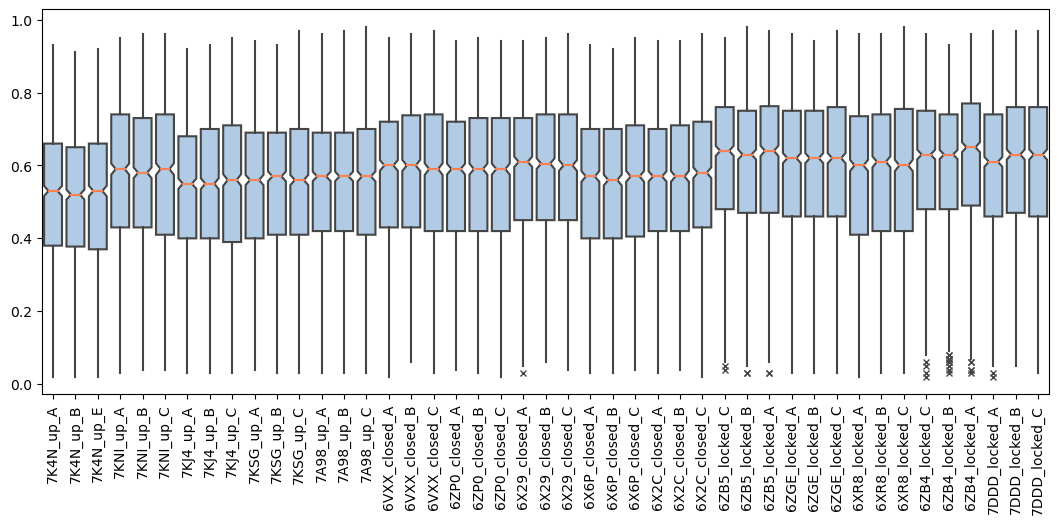

In [11]:
# visualise the spread of PM probabilities in each structure

plt.figure(figsize=(13, 5))
ax = sns.boxplot(data = PocketMiner_data_matrix.T,
                 notch=True, showcaps=False,
                 flierprops={"marker": "x"},
                 boxprops={"facecolor": (.4, .6, .8, .5)},
                 medianprops={"color": "coral"})

ax.set_xticklabels(list(PocketMiner_df.index), rotation=90)
# plt.savefig('prob_box_plot.png', dpi=300, bbox_inches='tight')
plt.show()

**Calculate proportion of residues with PM probabilities above the threshold:**

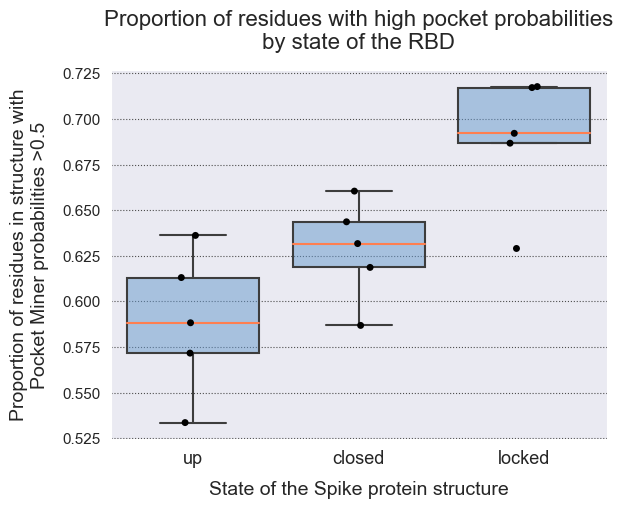

In [12]:
threshold = 0.5

# for each chain calculate the proportion of residues with probabilities above the threshold
all_res = np.sum(~np.isnan(PocketMiner_data_matrix), axis=1)
above_threshold = np.sum(PocketMiner_data_matrix > threshold, axis=1)

proportion = above_threshold / all_res
proportion_by_structure = above_threshold.reshape((-1, 3)).sum(axis=1) / all_res.reshape((-1, 3)).sum(axis=1)

# reshape table and plot by state
a = proportion_by_structure.reshape((3, -1))

sns.set_style("darkgrid", {"grid.color": ".3", 
                           "grid.linestyle": ":"})

ax = sns.boxplot(data = a.T, showcaps=True, showfliers = False,
                 boxprops={"facecolor": (.4, .6, .8, .5)},
                 medianprops={"color": "coral"})

sns.stripplot(data=a.T, ax=ax, color='black')

ax.set_xticklabels(['up', 'closed', 'locked'], fontsize = 13)
ax.tick_params(axis='y', labelsize=11)
ax.set_title("Proportion of residues with high pocket probabilities\nby state of the RBD",
             fontsize = 16, pad=15)
ax.set_ylabel("Proportion of residues in structure with\nPocket Miner probabilities >0.5",
              fontsize = 14, labelpad=10)
ax.set_xlabel("State of the Spike protein structure",
              fontsize = 14, labelpad=10)

# plt.savefig('prob_above_50_by_state_box_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [51]:
# generate and save table to analyse in R using GLM with binomial errors

state = ['up'] * 5 + ['closed'] * 5 + ['locked'] * 5
data_for_R = pd.DataFrame(list(zip(above_threshold.reshape((-1, 3)).sum(axis=1), 
                                   all_res.reshape((-1, 3)).sum(axis=1),
                                   state)),
                          columns =['high_prob', 'all_res', 'state'])

data_for_R.to_csv('data/high_probability_residues_by_state.csv', index=False)

## Is there a relationship between PM probability and contact with any pocket?

In [13]:
probs = PocketMiner_df.values.reshape((3,-1))
vols  = pocket_volume_df.values.reshape((3,-1))

0. Correlation is 0.24115007242929895, with p-value being 4.989708078526093e-202
1. Correlation is 0.24068717844105952, with p-value being 1.2717623171934102e-194
2. Correlation is 0.2379815729339618, with p-value being 6.244836371361405e-206


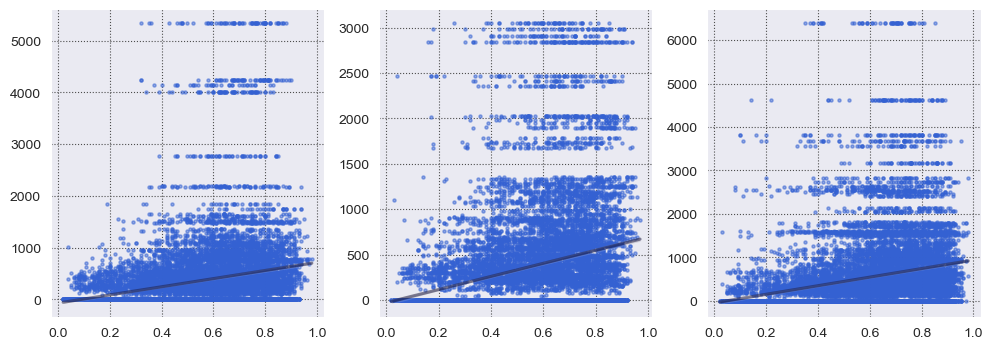

In [14]:
# let's visualise each residue by state

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

sns.set_style("darkgrid", {"grid.color": ".3", 
                           "grid.linestyle": ":"})

for i in range(3):
    
    x_vals = probs[i, :][probs[i, :] > -0.5]
    y_vals = vols[i, :][vols[i, :] > -0.5]
    
    r, p = stats.pearsonr(x_vals, y_vals)
    print(f'{i}. Correlation is {r}, with p-value being {p}')
    
    sns.regplot(x=x_vals,
                y=y_vals,
                ax = ax[i],
                line_kws={'color': '#1c193d', 'alpha': 0.5},
                scatter_kws={'alpha':0.5, 's': 5, 'color': '#3461d2'})
    
# plt.savefig('pocket_volume_vs_PM_probability.png', dpi=300, bbox_inches='tight')

In [16]:
# transform data for proper statisticsl testing in R

data_for_R = []
threshold = 0.5

probs_matrix  = PocketMiner_df.values.reshape((15,-1))
vols_matrix   = pocket_volume_df.values.reshape((15,-1))
pocket_matrix = pocket_contact_df.values.reshape((15,-1))

states = ['up'] * 5 + ['closed'] * 5 + ['locked'] * 5
for i, (probs, vols, pocket_ids, state) in enumerate(zip(probs_matrix, vols_matrix, pocket_matrix, states)):
    
    # get pocoket ids excluding -1 (aka no data)
    ids = np.unique(pocket_ids)[1:]
    
    # for each pocket get the volume and the average PM probability
    for d in ids:
        av_prob = np.average(probs[pocket_ids == d])
        vol = vols[pocket_ids == d][0]
        data_for_R.append([state, vol, av_prob])
    
# save data for analysis in R
data_for_R = pd.DataFrame(data=data_for_R,
                          columns =['state', 'volume', 'av_probability'])

data_for_R.to_csv('data/pocket_volume_vs_PM_probability_by_state.csv', index=False)

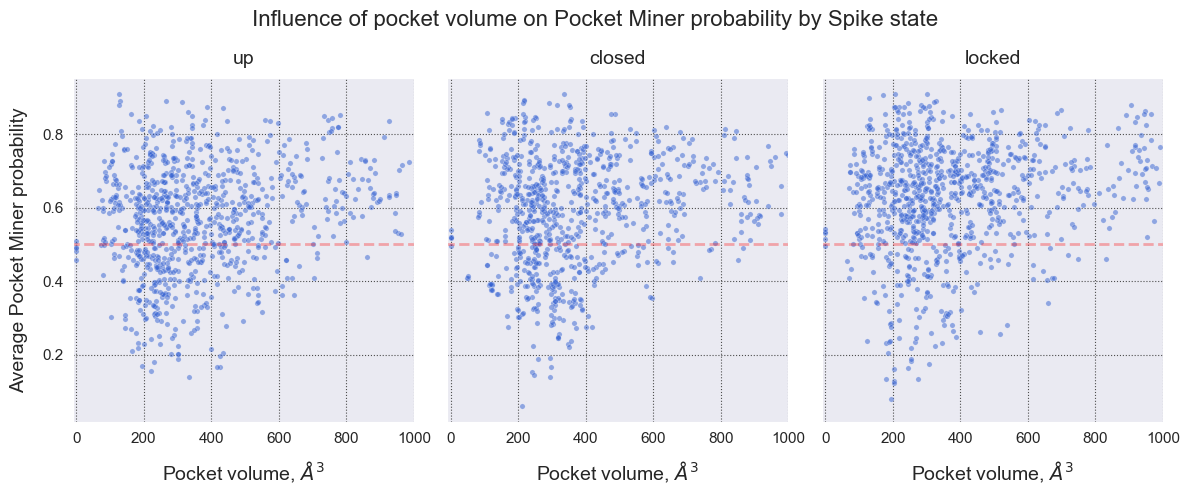

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5), sharey='all')
fig.suptitle("Influence of pocket volume on Pocket Miner probability by Spike state", fontsize = 16)

for i, state in enumerate(['up', 'closed', 'locked']):
    
    subset = data_for_R[data_for_R['state'] == state]
    
    sns.scatterplot(data=subset,
                   x='volume',
                   y='av_probability',
                   ax=ax[i],
                   alpha=0.5, s=15, color='#3461d2')
    
    ax[i].hlines(y=0.5, xmin=-20, xmax=1010, alpha=0.3,
                 linewidth=2, linestyles='dashed', color='r')
    
    # to scale 
    ax[i].set_xlim((-10,1000))
    
    ax[i].tick_params(axis='y', labelsize=11)
    ax[i].tick_params(axis='x', labelsize=11)
    
    ax[i].set_title(state, fontsize = 14, pad=10)

    ax[i].set_xlabel("Pocket volume, $Å^3$", fontsize = 14, labelpad=10)

ax[0].set_ylabel("Average Pocket Miner probability", fontsize = 14, labelpad=10)

plt.tight_layout()
# plt.savefig('volume_vs_PM_by_state.png', dpi=300, bbox_inches='tight')
plt.show()

## Predictions for known cryptic pockets

### MM pocket identifyed through MD

The residues from this pocket were adentified accordig to MD paper on Spike structure and cryptic pocket discovery

In [18]:
MM_residues = """SER 316
ASN 317
PHE 318
ARG 319
VAL 320
GLN 321
PRO 322
THR 323
GLU 324
SER 591
PHE 592
GLY 593
GLY 594
VAL 595
SER 596
VAL 597
VAL 610
LEU 611
TYR 612
GLN 613
ASP 614
VAL 615
ASN 616
CYS 617
THR 618
GLU 619
VAL 620
PRO 621
VAL 622
ALA 623
ILE 624
HSD 625
ALA 626
ASP 627
GLN 628
ARG 646
ALA 647
GLY 648
CYS 649
LEU 650
ILE 651"""

MM_residues = MM_residues.split('\n')
MM_residues = [(int(el[-3:]), three_to_one_leter_name[el[:3]]) for el in MM_residues]
MM_residues.sort(key=lambda x: x[0])

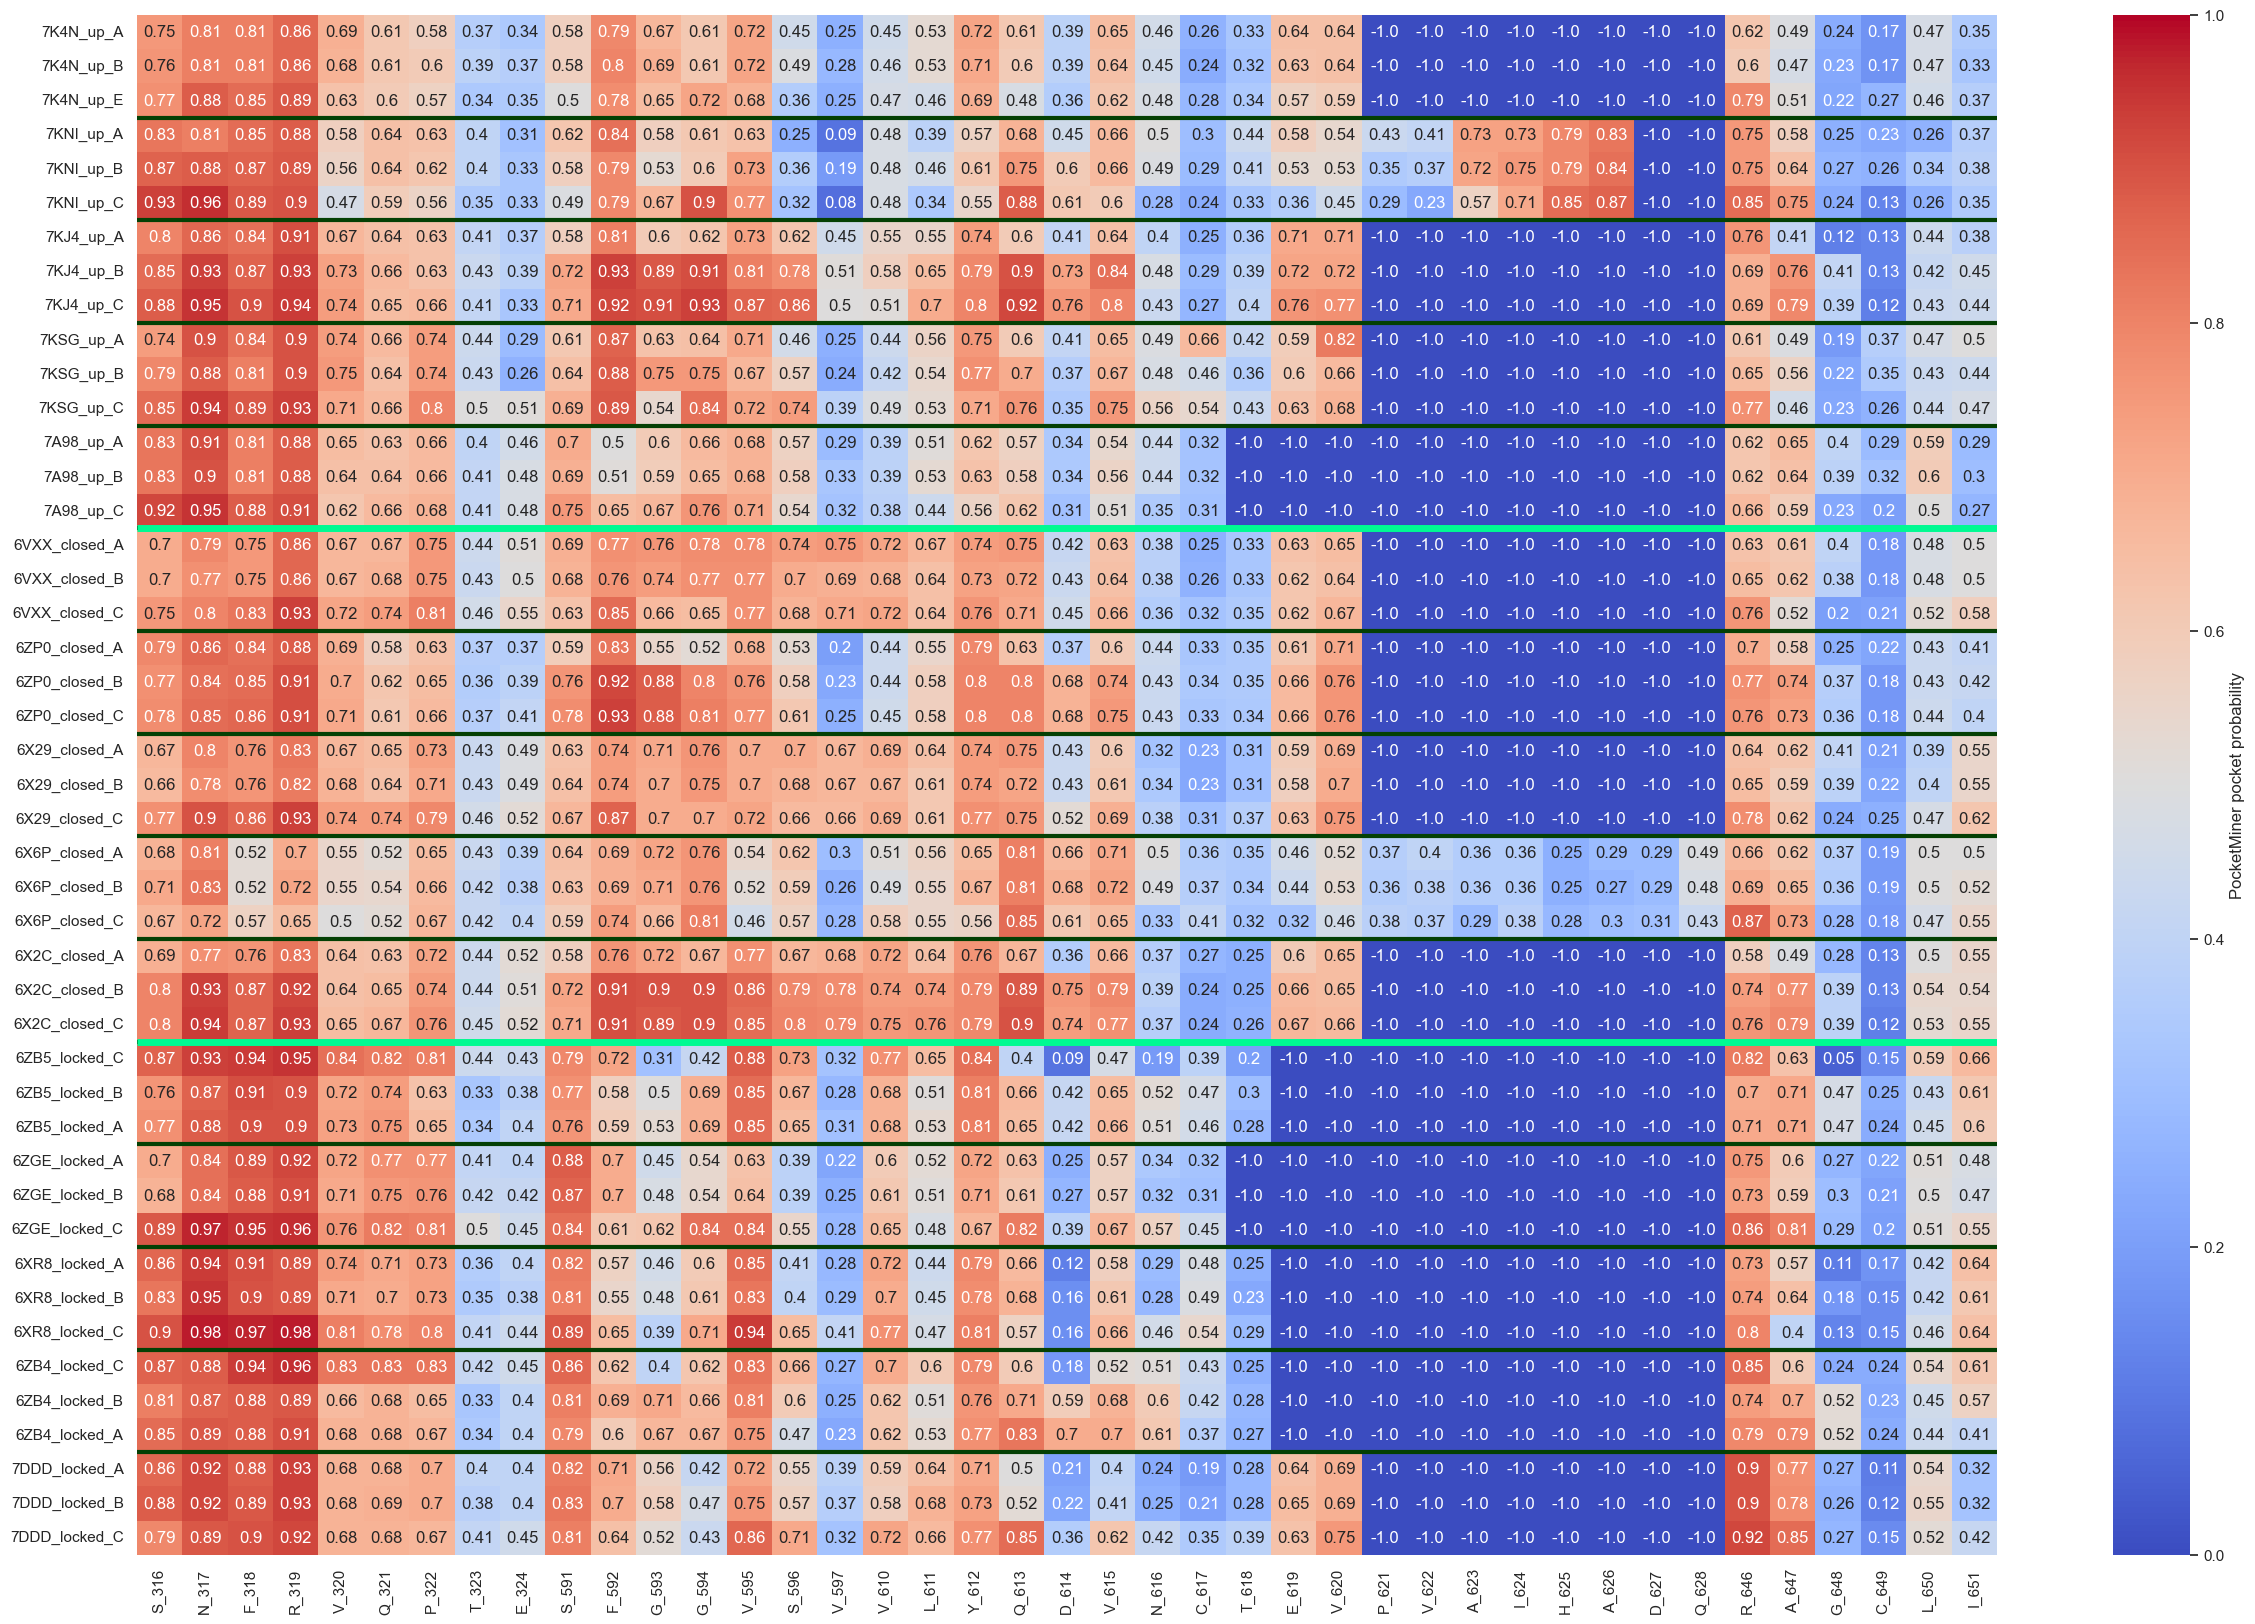

In [19]:
# heatmap of PM probabilities
ResidueHeatMap(PocketMiner_df,
               MM_residues,
               Spike_protein)

# plt.savefig('MM_prob_heatmap.png', dpi=300, bbox_inches='tight')

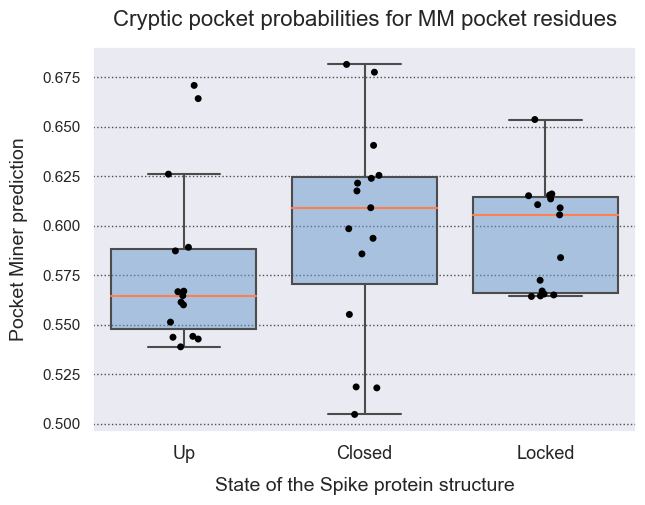

In [20]:
MMpocket_data = PM_ResidueBoxPlot(data=PocketMiner_df,
                                  res_list=MM_residues,
                                  title="Cryptic pocket probabilities for MM pocket residues")

# plt.savefig('MM_prob_boxplot.png', dpi=300, bbox_inches='tight')

In [21]:
# PM probability data by state data for R

data_for_R = pd.DataFrame(data= list(zip(
                                        ['up']*15 + ['closed']*15 + ['locked']*15,
                                        [el.split('_')[0] for el in PocketMiner_df.index],
                                        MMpocket_data.reshape((1,-1))[0],
                                        )),
                          columns =['state', 'structure', 'probability'])

data_for_R.to_csv('data/MM_probabilities.csv', index=False)  

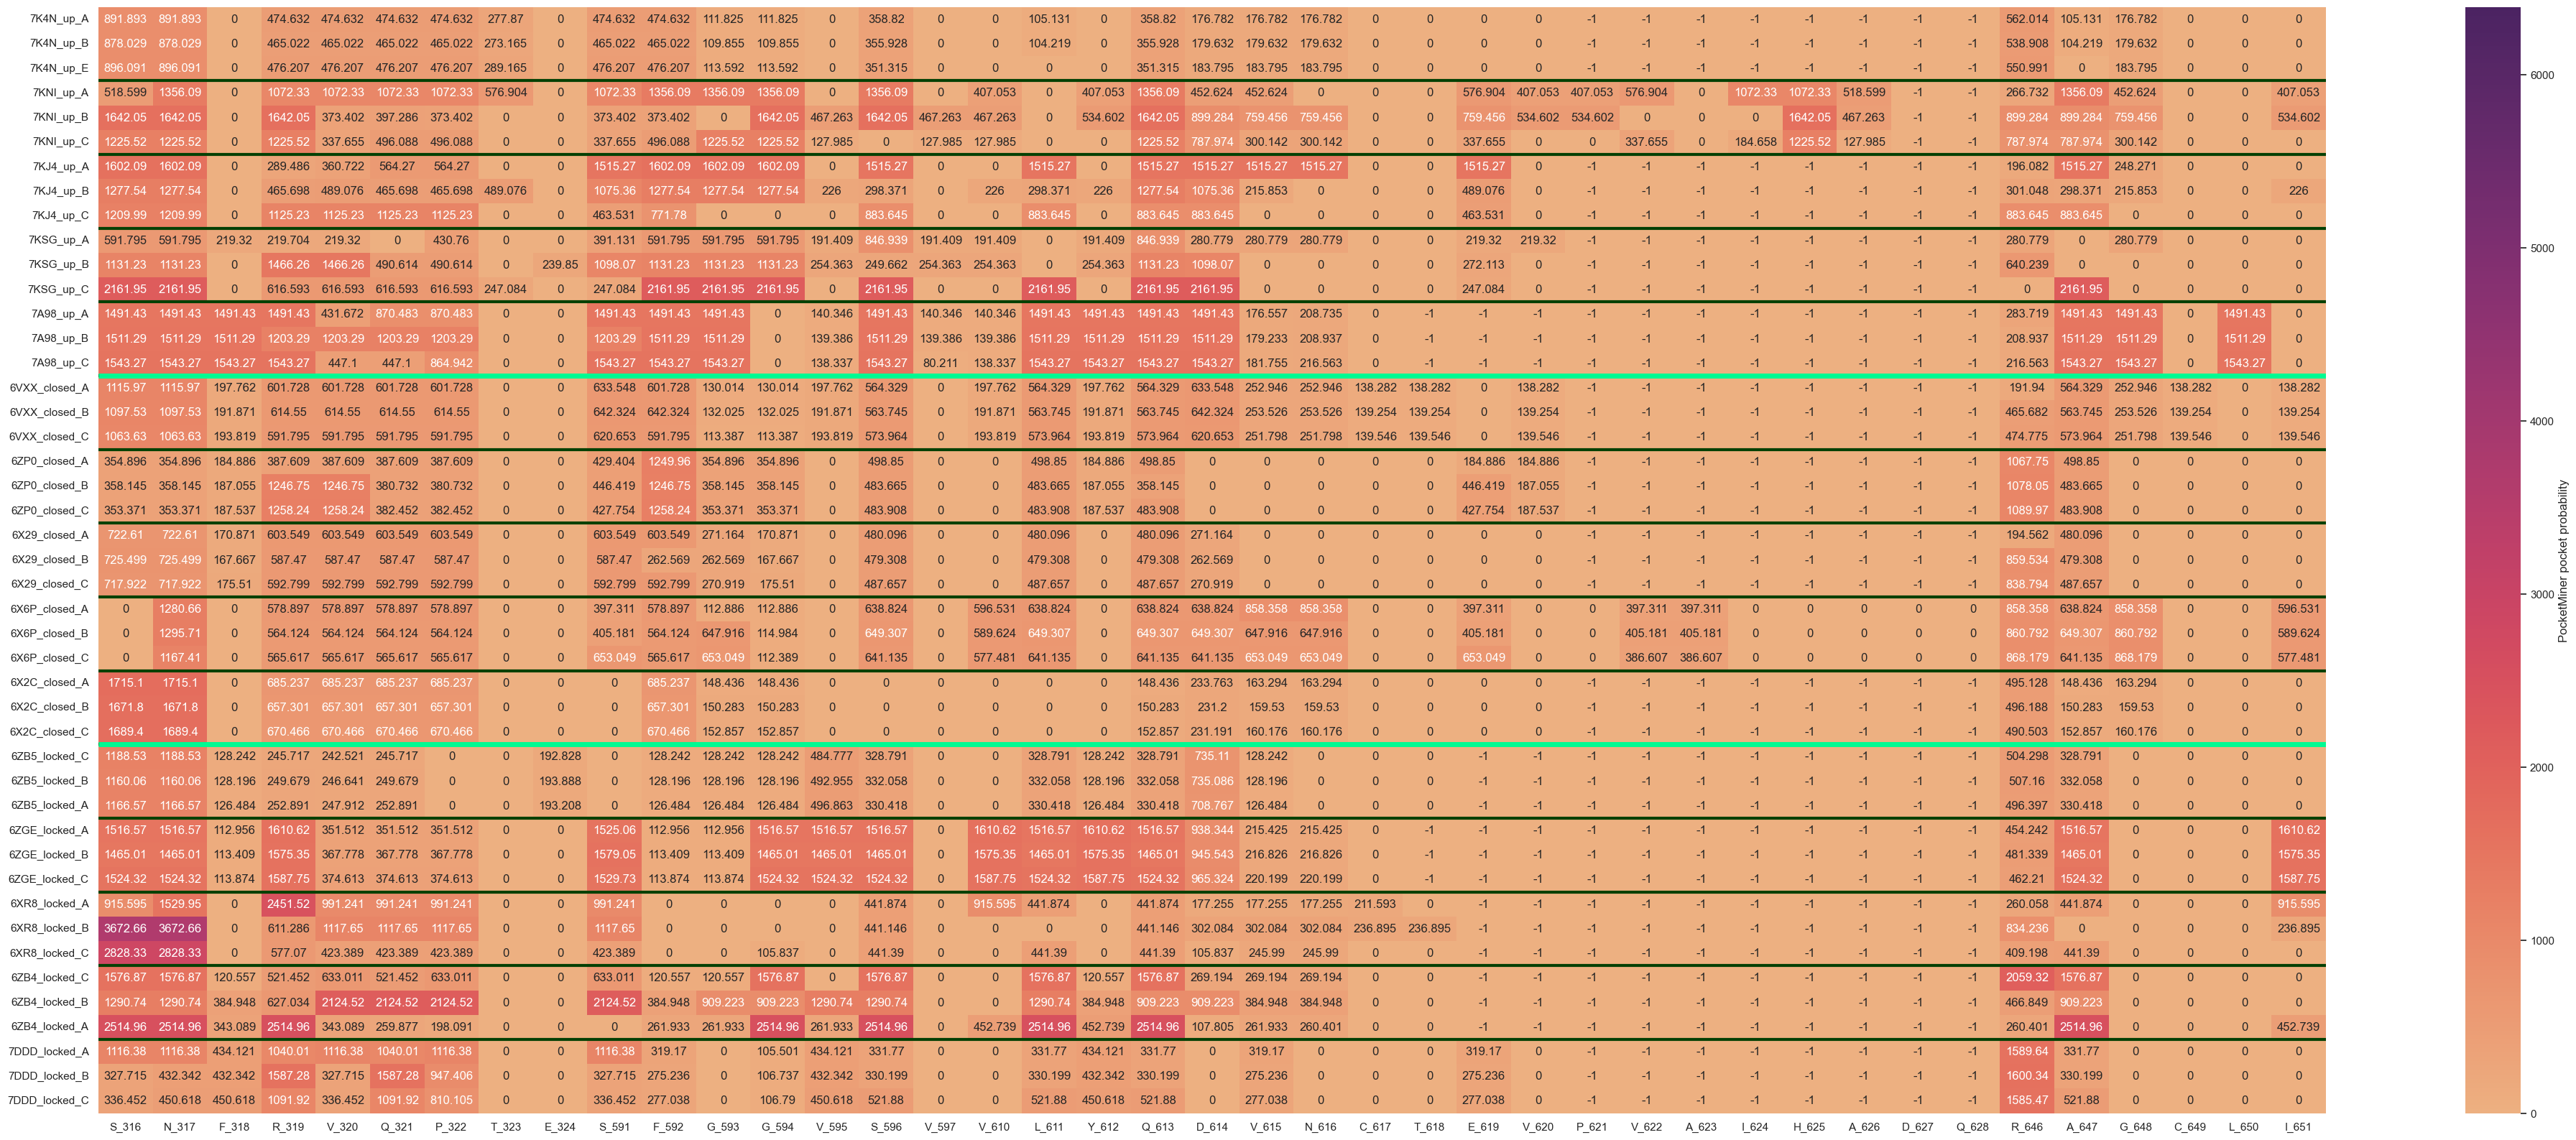

In [22]:
# heatmap of contacting residues

ResidueHeatMap(pocket_volume_df,
               MM_residues,
               Spike_protein,
               size=(50, 20))

The helical loop is missing in the majority of structures. In a structure where it's present the probability is quite low.

There are residues with rather high probabilities: 317 318 591 592 593 594 613 646

### LA pocket

In [24]:
# residues contacting with LA
# selected within 5Å threshold from LA in 7JJI structure

LA_residues = """LYS 417
GLY 416
GLN 409
THR 415
ARG 408
TYR 369
ALA 372
LEU 368
TYR 365
PHE 374
LEU 387
PHE 377
ILE 434
ALA 363
PHE 338
PHE 342
CYS 336
VAL 341
VAL 524
ILE 358
PHE 392
VAL 395
LEU 513
PHE 515"""

LA_residues = LA_residues.split('\n')
LA_residues = [(int(el[-3:]), three_to_one_leter_name[el[:3]]) for el in LA_residues]
LA_residues.sort(key=lambda x: x[0])

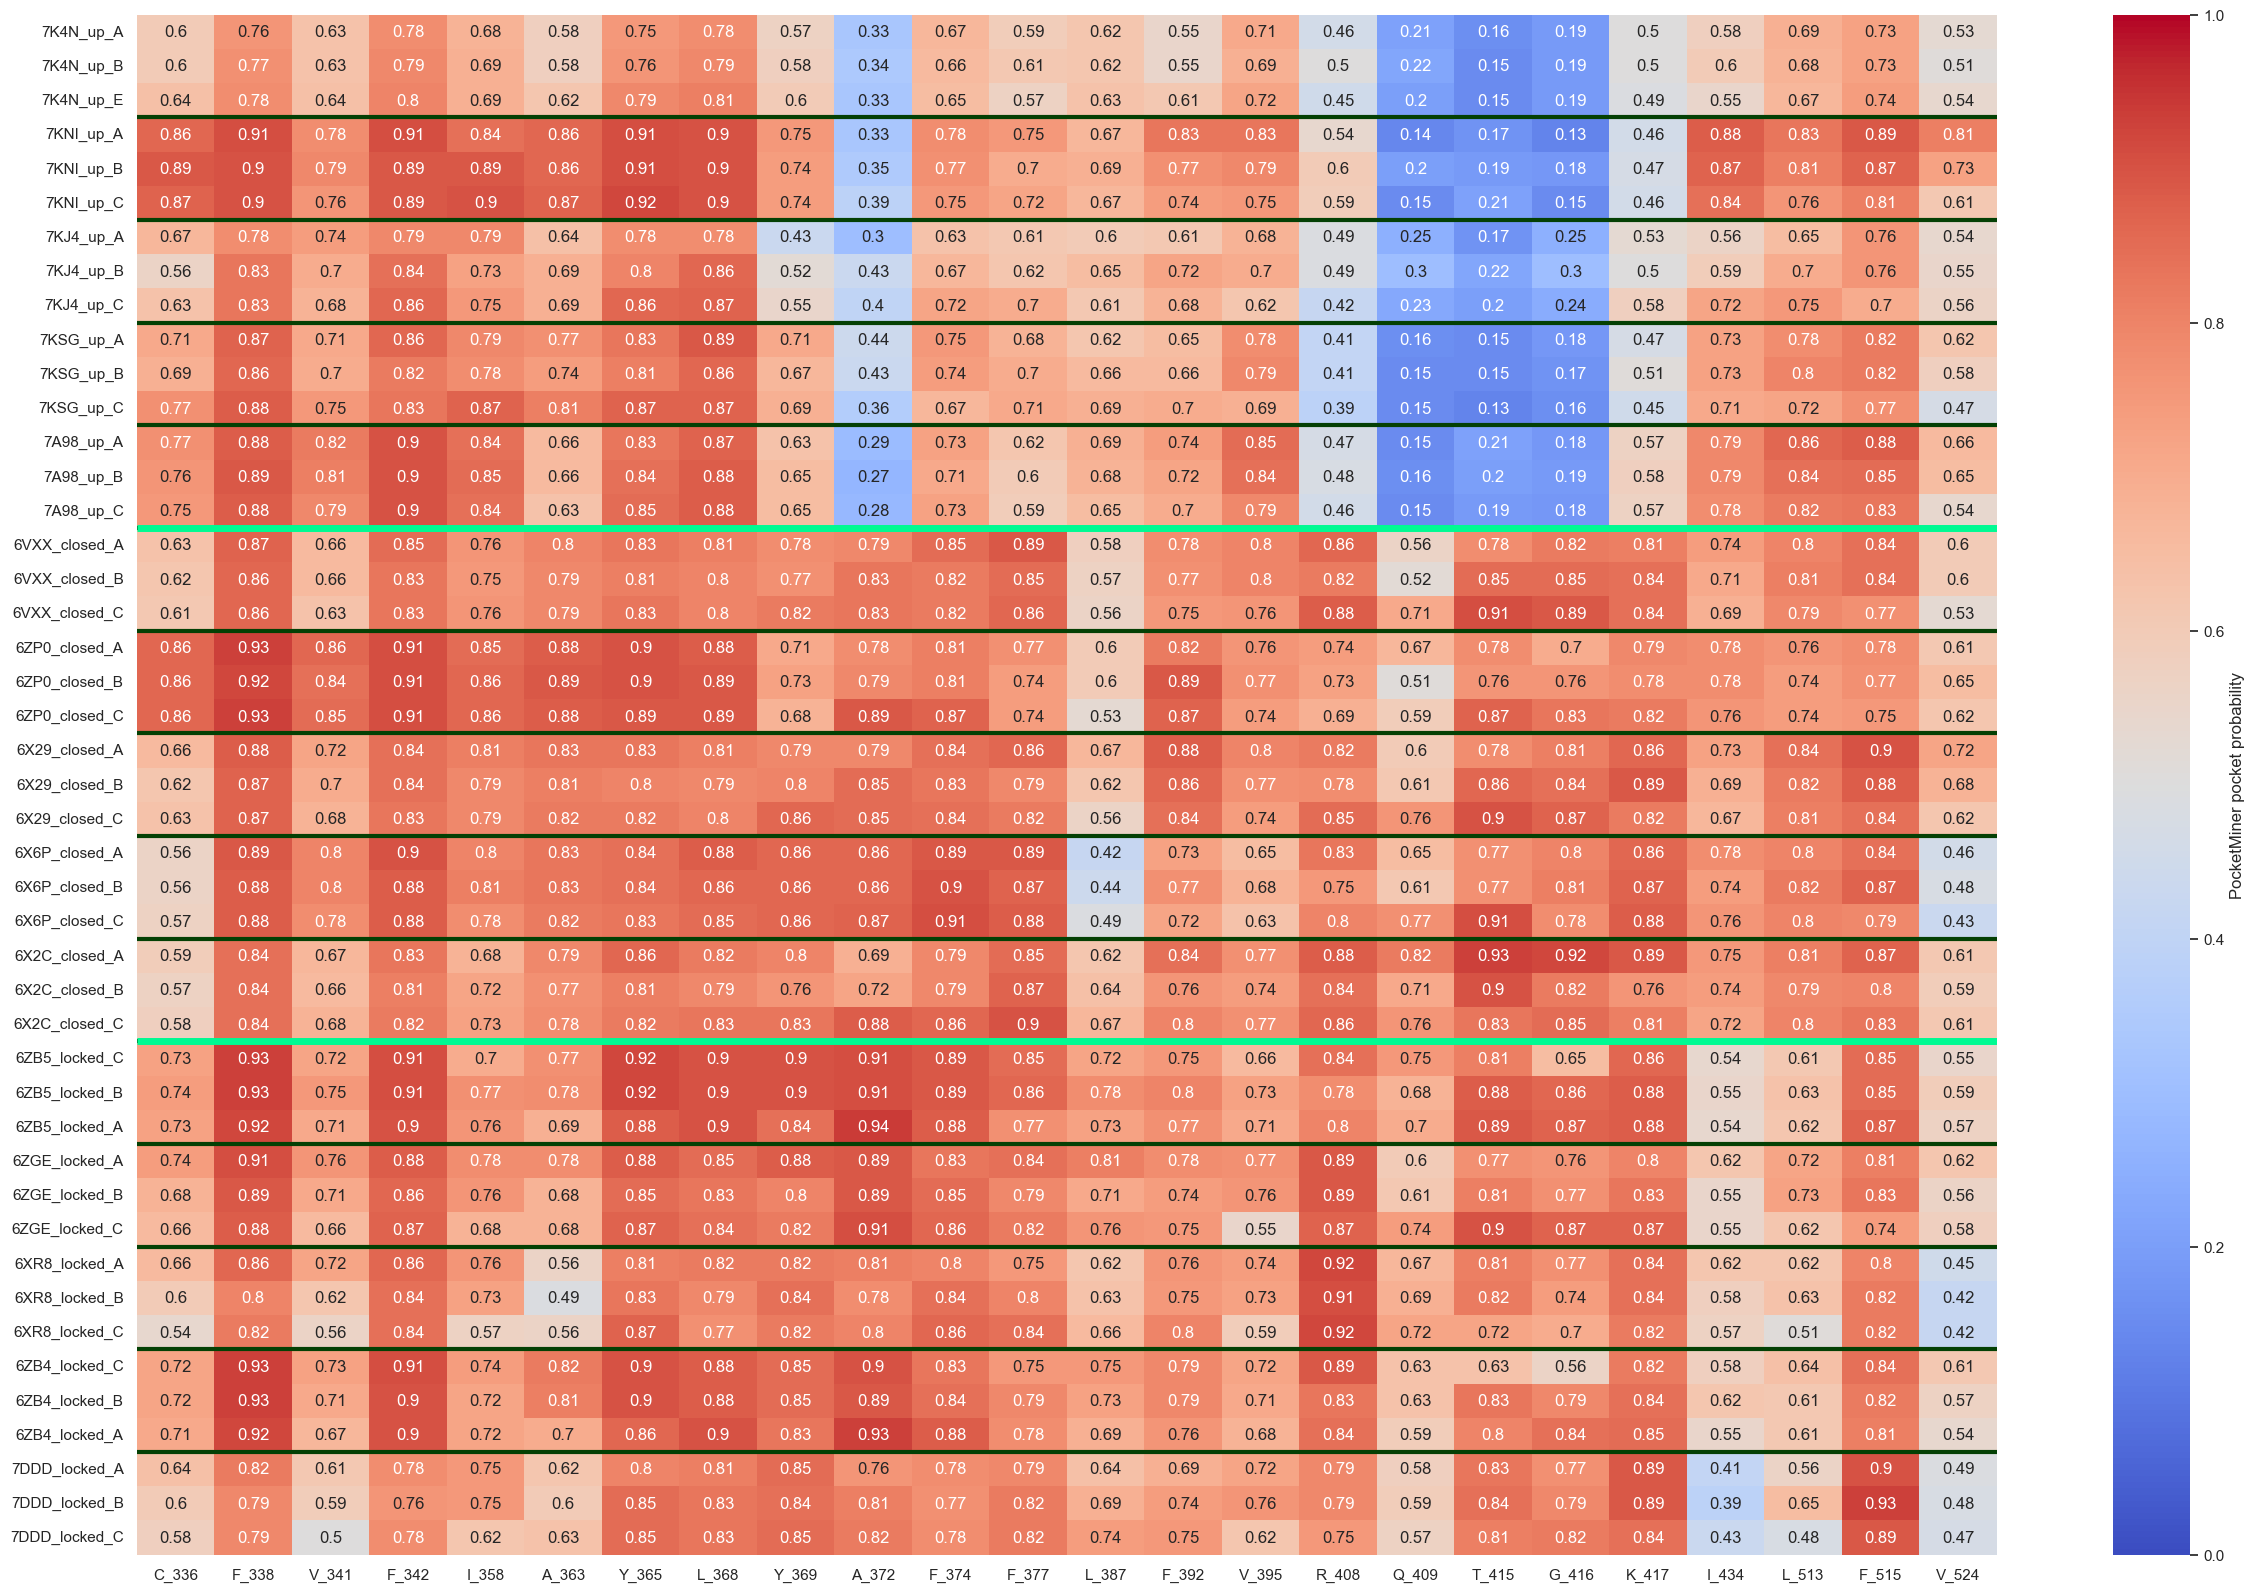

In [25]:
ResidueHeatMap(PocketMiner_df,
               LA_residues,
               Spike_protein)

# plt.savefig('LA_prob_heatmap.png', dpi=300, bbox_inches='tight')

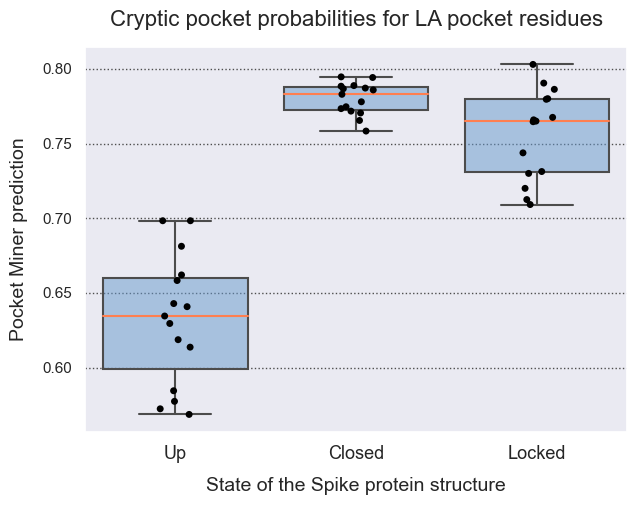

In [27]:
LApocket_data = PM_ResidueBoxPlot(PocketMiner_df,
                                  LA_residues,
                                  "Cryptic pocket probabilities for LA pocket residues")

# plt.savefig('LA_prob_boxplot.png', dpi=300, bbox_inches='tight')

In [28]:
# PM probability data by state data for R

data_for_R = pd.DataFrame(data= list(zip(
                                        ['up']*15 + ['closed']*15 + ['locked']*15,
                                        [el.split('_')[0] for el in PocketMiner_df.index],
                                        LApocket_data.reshape((1,-1))[0],
                                        )),
                          columns =['state', 'structure', 'probability'])

data_for_R.to_csv('data/LA_probabilities.csv', index=False)    

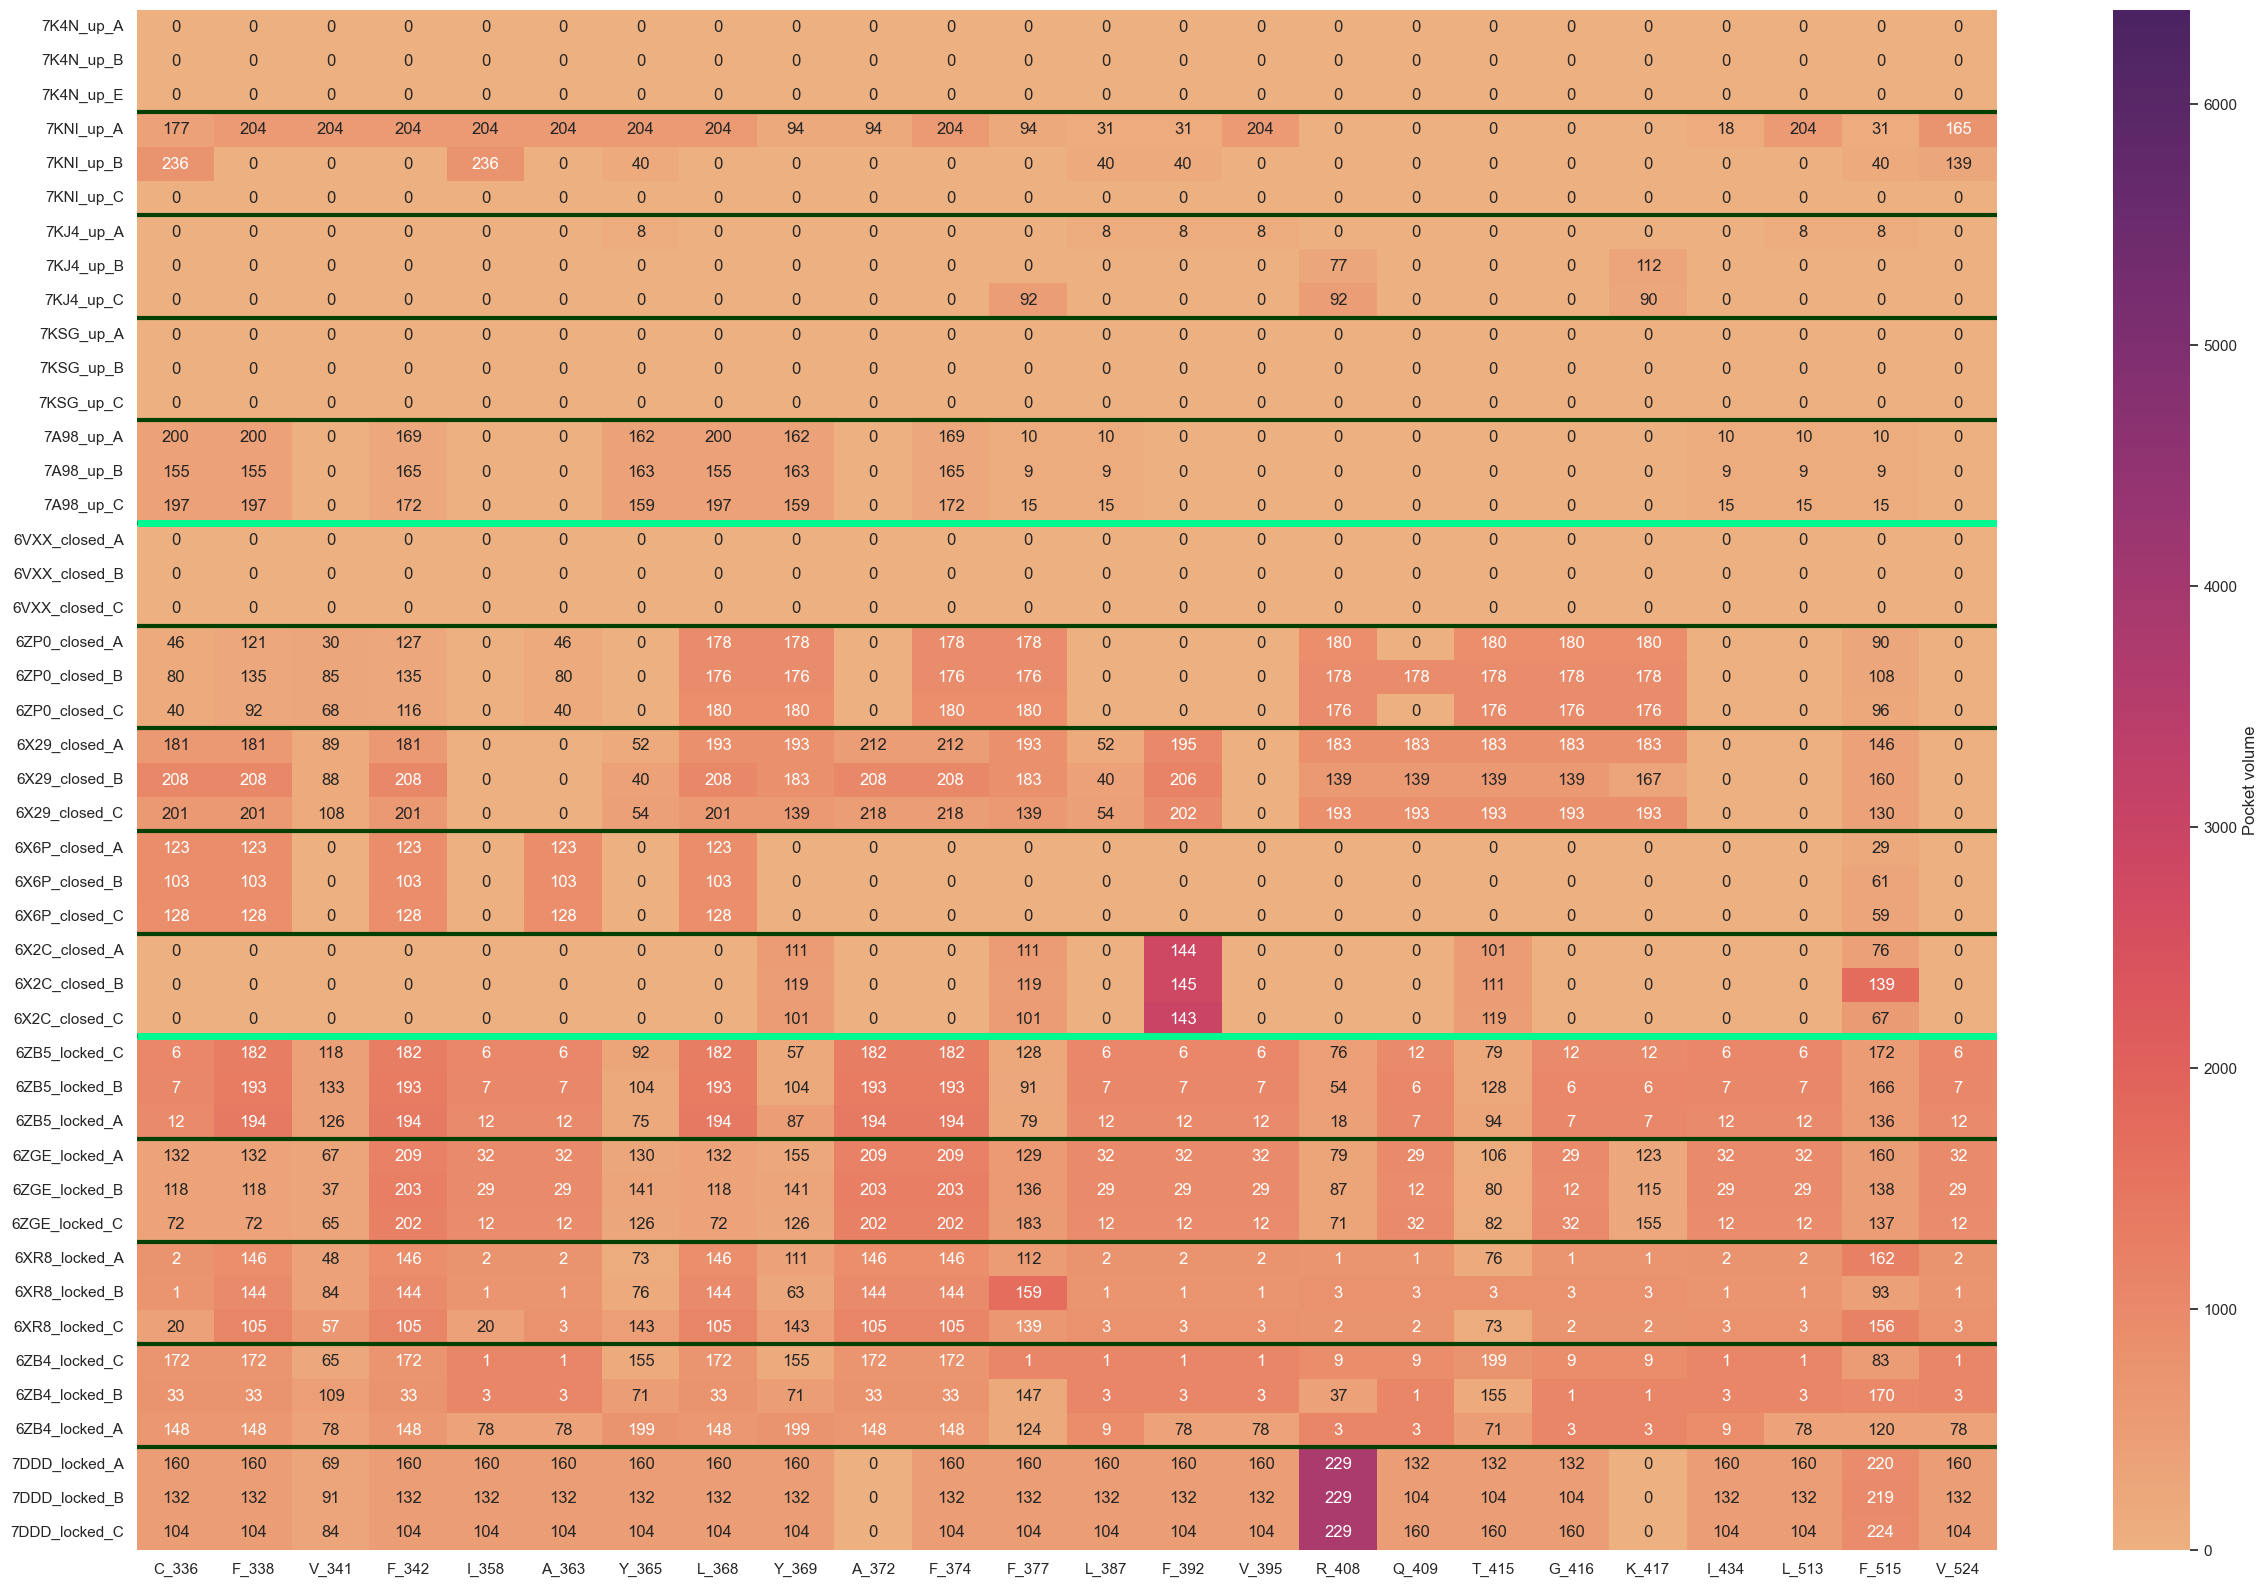

In [30]:
# heatmap of contacting residues
ResidueHeatMap(pocket_volume_df,
               LA_residues,
               Spike_protein,
               annotate_from=pocket_contact_df)

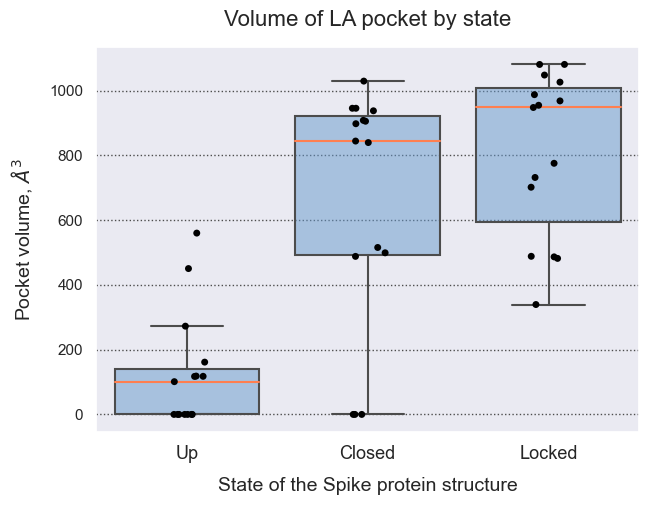

In [89]:
Vol_ResidueBarPlot(pocket_volume_df,
                   pocket_contact_df,
                   LA_residues,
                   "Volume of LA pocket by state")

plt.savefig('LA_pocket_vol_barplot.png', dpi=300, bbox_inches='tight')
plt.show()

This automated selection of contacting pocket is sometimes inaccurate and in fact its a cavity situated near the actual pocket. Therefore, a manual inspection was perfomed to generate better plot:

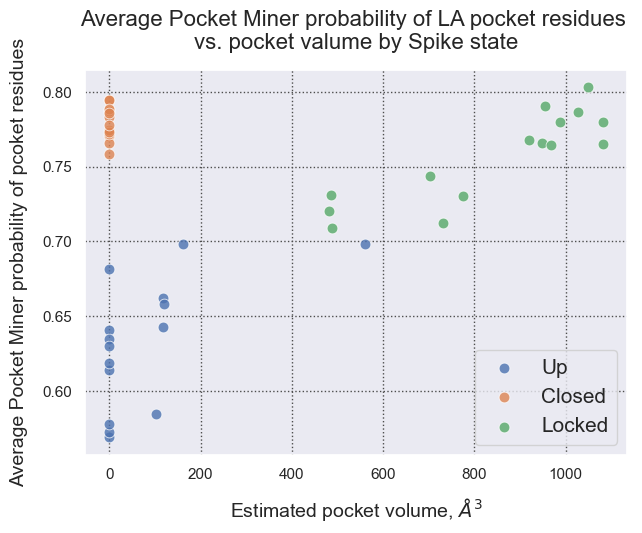

In [31]:
# these are indexes of the pockets for each chain in each structure
pockets_LA = np.array([0, 0, 0, 204, 40, 0, 8, 0, 0, 0, 0, 0, 10, 9, 15,  # up
                       0, 0, 0,   0,  0, 0, 0, 0, 0, 0, 0, 0,  0, 0,  0,  # closed
                       12, 6, 7, 29, 12, 32, 1, 3, 2, 9, 1, 3, 132, 104, 160]) # locked

# now plot
sns.set_style("darkgrid", {"grid.color": ".3", 
                           "grid.linestyle": ":"})

plt.figure(figsize=(7, 5))
    
# get volumes 
volumes = []
for i, pocket_id in enumerate(pockets_LA):
    if pocket_id == 0:
        volumes.append(0)
    else:
        row_data = pocket_volume_df.iloc[i, :].values
        volumes.append(row_data[pocket_contact_df.iloc[i, :].values == pocket_id][0])
volumes=np.array(volumes).reshape((3,-1))
    
ax = sns.scatterplot(x = volumes[0], y = LApocket_data[0], label='Up', s=60, alpha=0.8)
sns.scatterplot(x = volumes[1], y = LApocket_data[1], label='Closed', s=60, alpha=0.8)
sns.scatterplot(x = volumes[2], y = LApocket_data[2], label='Locked', s=60, alpha=0.8)

ax.legend(fontsize=15)
ax.tick_params(axis='y', labelsize=11)
ax.tick_params(axis='x', labelsize=11)
ax.set_title("Average Pocket Miner probability of LA pocket residues \nvs. pocket valume by Spike state",
             fontsize = 16, pad=15)
ax.set_ylabel("Average Pocket Miner probability of pcoket residues",
              fontsize = 14, labelpad=10)
ax.set_xlabel("Estimated pocket volume, $Å^3$",
              fontsize = 14, labelpad=10)

# plt.savefig('LA_pob_vs_vol_ajusted.png', dpi=300, bbox_inches='tight')
plt.show()

In [32]:
# save data for ANCOVA analysis in R

data_for_R = pd.DataFrame(data= list(zip(
                                        ['up']*15 + ['closed']*15 + ['locked']*15,
                                        LApocket_data.reshape((1, -1))[0],
                                        volumes.reshape((1, -1))[0],
                                        )),
                          columns =['state', 'probability', 'volume'])

data_for_R.to_csv('data/LA_probabilities_vs_volume.csv', index=False)   

### PS pocket

In [33]:
# residues contacting with PS
# selected within 5Å threshold from PS in 7JJI structure

PS_residues = """PHE 168
PRO 230
LEU 229
ASP 228
VAL 227
ILE 203
LEU 226
PHE 192
SER 205
HIS 207
ARG 190
GLU 96
ILE 101
ASN 99
TRP 104
GLY 103
ARG 102
ASN 121
PHE 175
ILE 119
VAL 126
SER 172
GLN 173
TYR 170
ILE 128"""

PS_residues = PS_residues.split('\n')
PS_residues = [(int(el[-3:]), three_to_one_leter_name[el[:3]]) for el in PS_residues]
PS_residues.sort(key=lambda x: x[0])

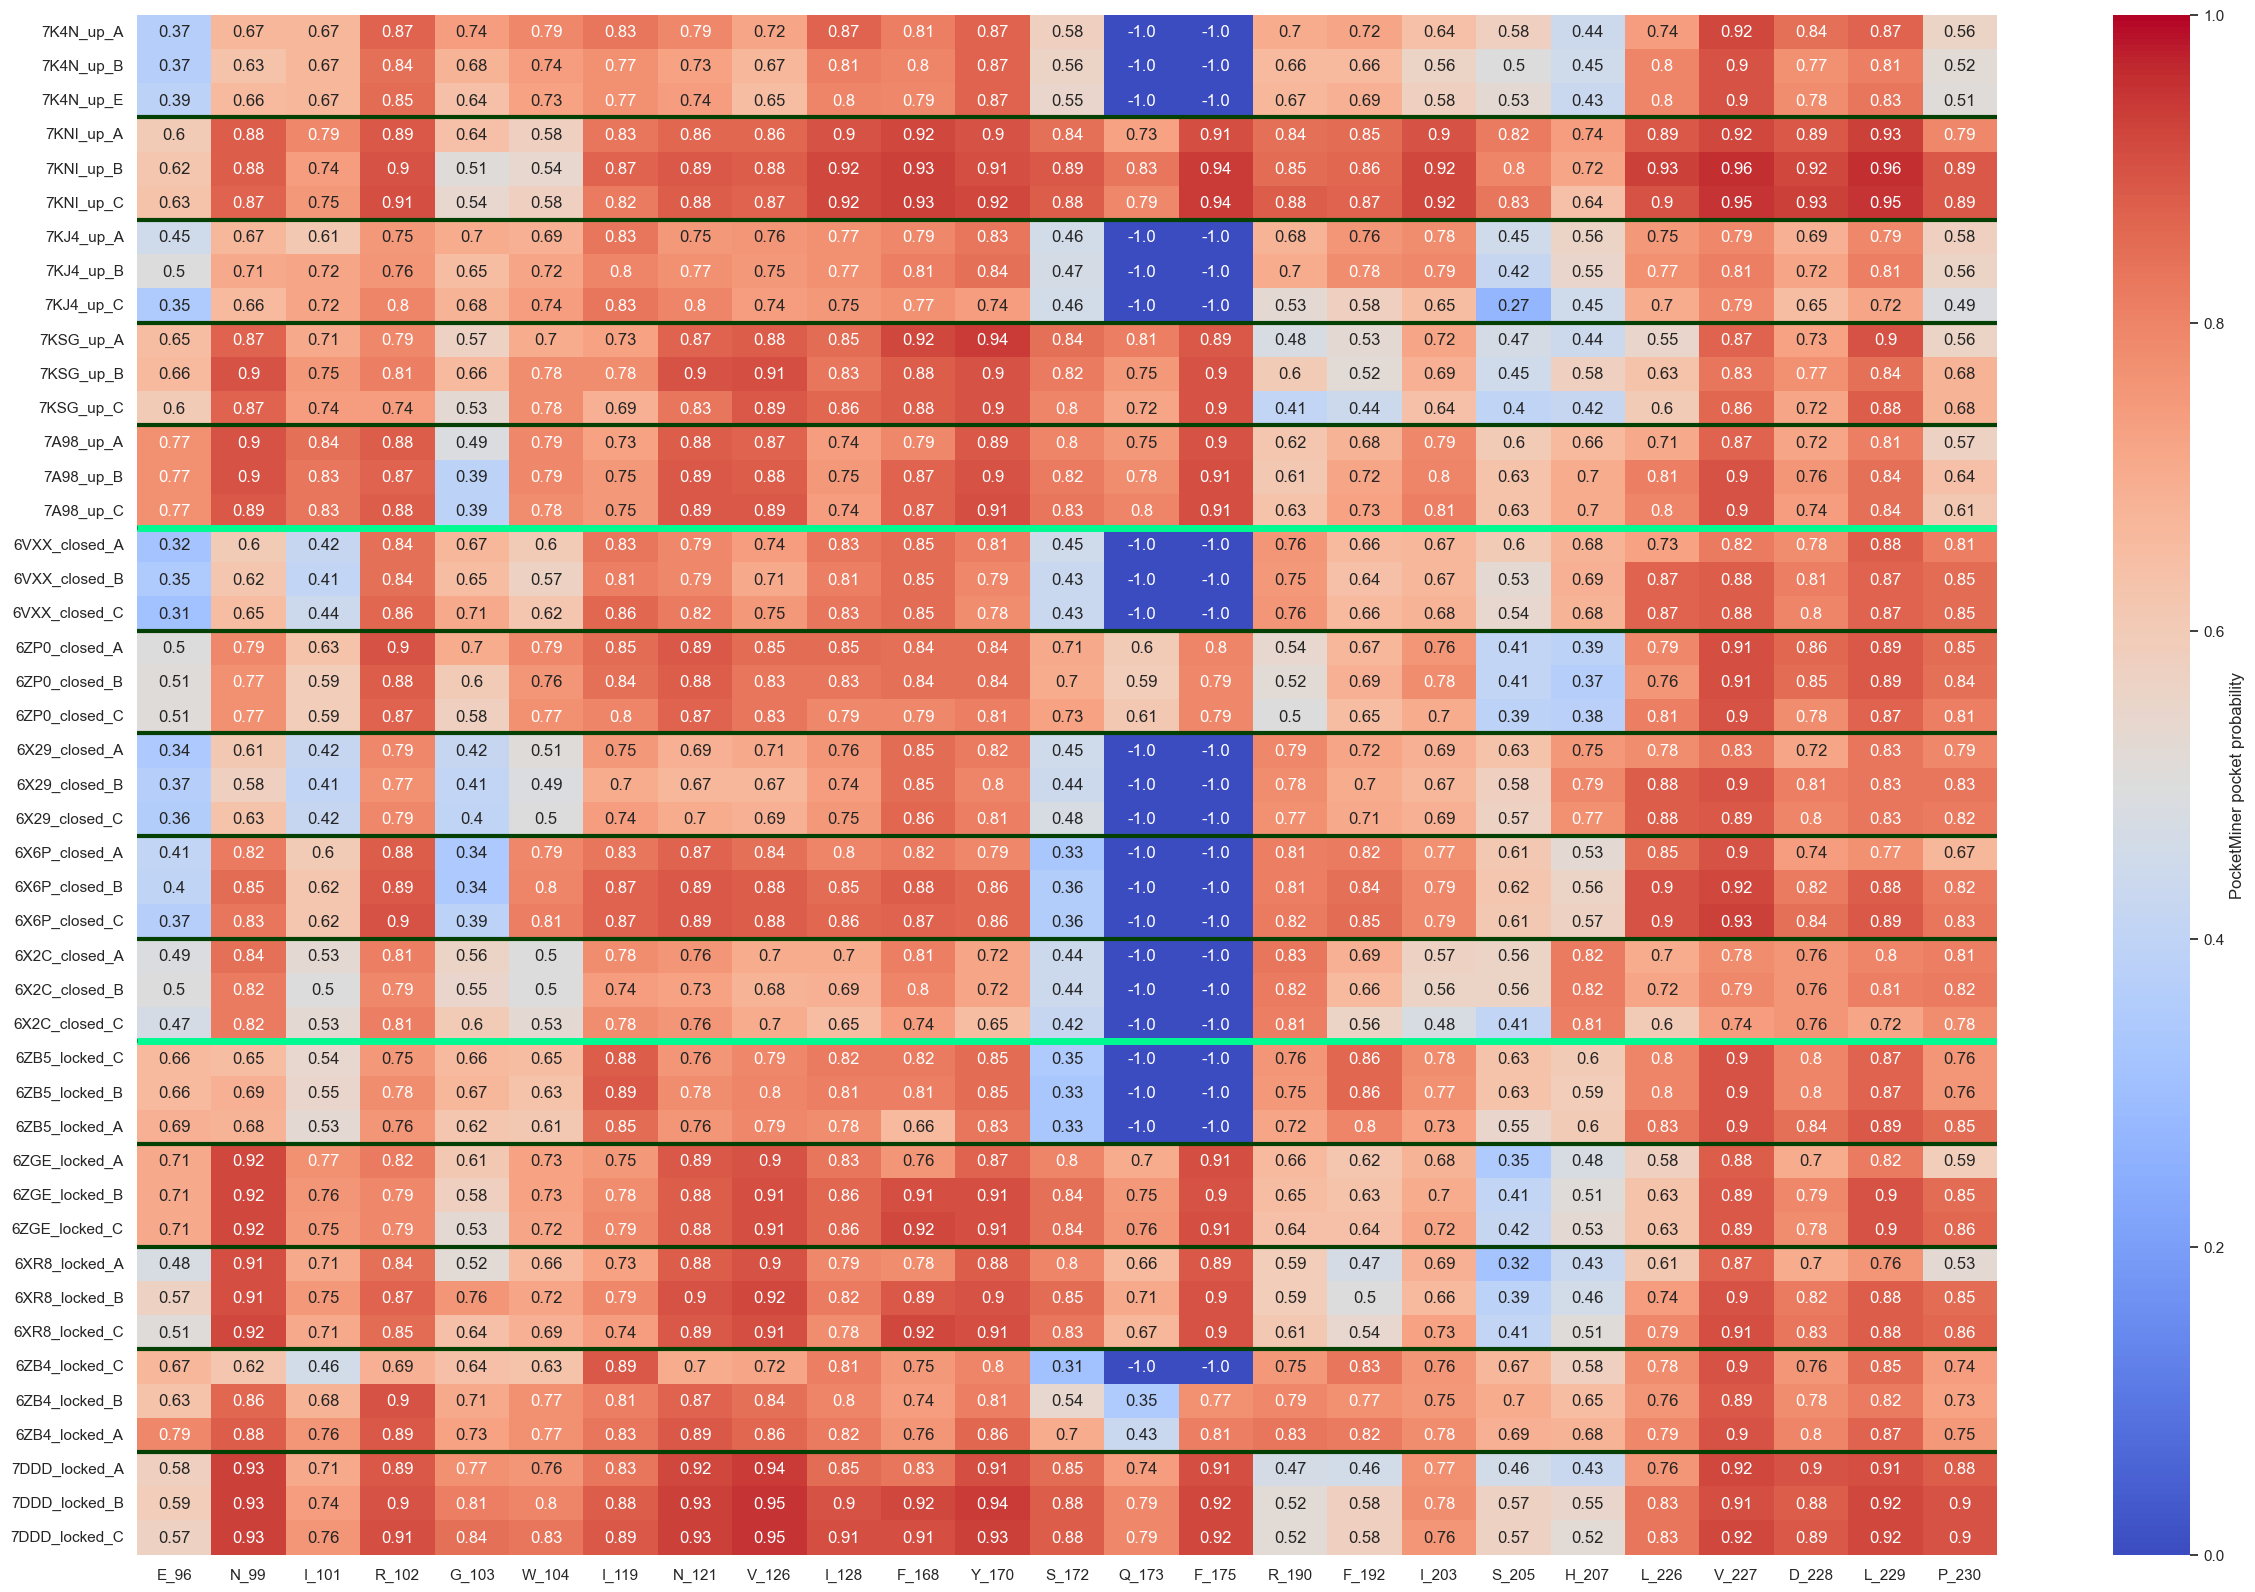

In [34]:
ResidueHeatMap(PocketMiner_df,
               PS_residues,
               Spike_protein)

# plt.savefig('PS_prob_heatmap.png', dpi=300, bbox_inches='tight')

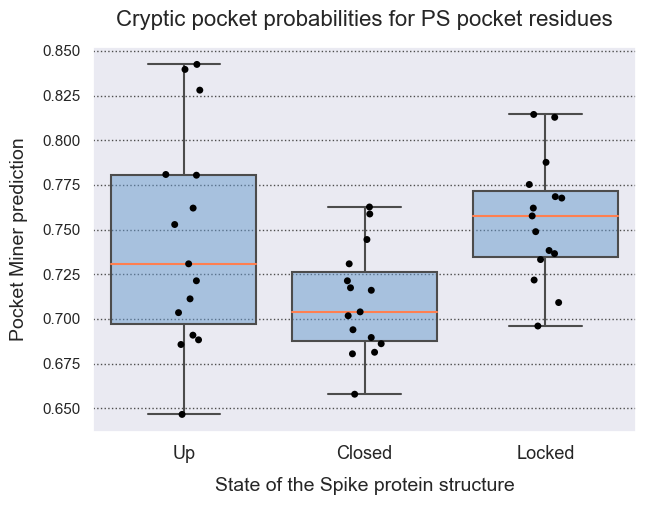

In [35]:
PSpocket_data = PM_ResidueBoxPlot(PocketMiner_df,
                                  PS_residues,
                                  "Cryptic pocket probabilities for PS pocket residues")

# plt.savefig('PS_prob_boxplot.png', dpi=300, bbox_inches='tight')

In [36]:
# PM probabilities by states data for analysis in R

data_for_R = pd.DataFrame(data= list(zip(
                                        ['up']*15 + ['closed']*15 + ['locked']*15,
                                        [el.split('_')[0] for el in PocketMiner_df.index],
                                        PSpocket_data.reshape((1,-1))[0],
                                        )),
                          columns =['state', 'structure', 'probability'])

data_for_R.to_csv('data/PS_probabilities.csv', index=False)    

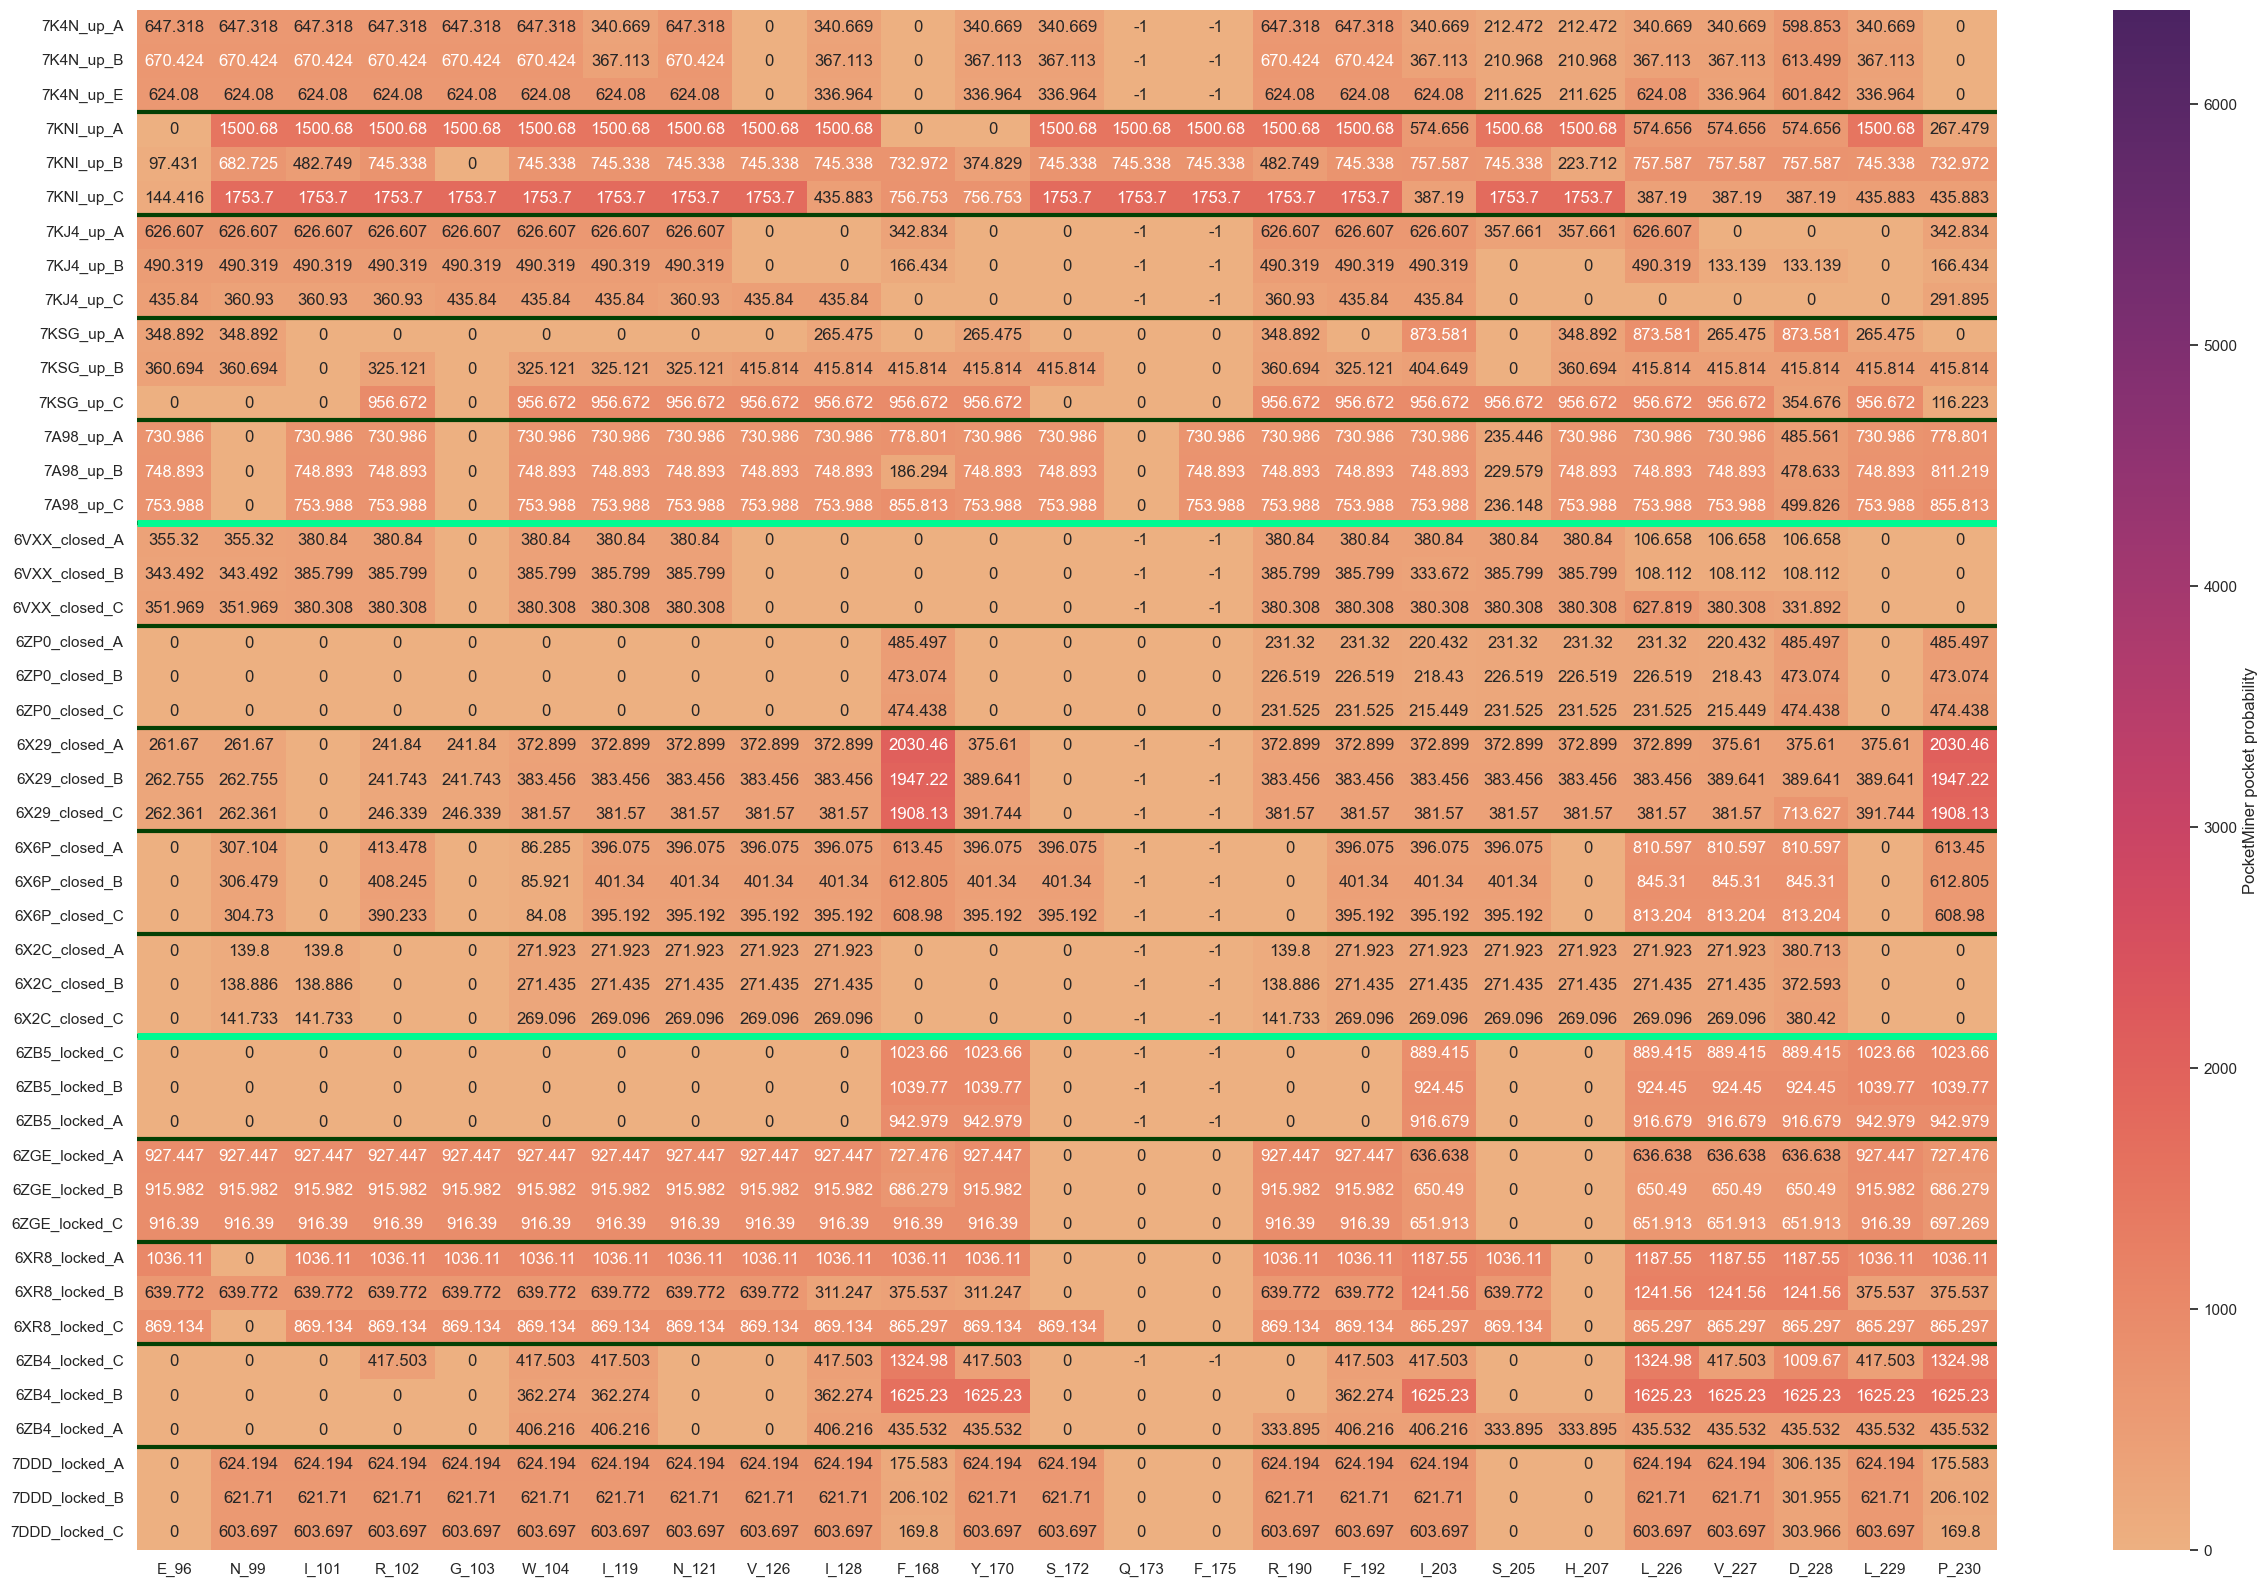

In [37]:
ResidueHeatMap(pocket_volume_df,
               PS_residues,
               Spike_protein)

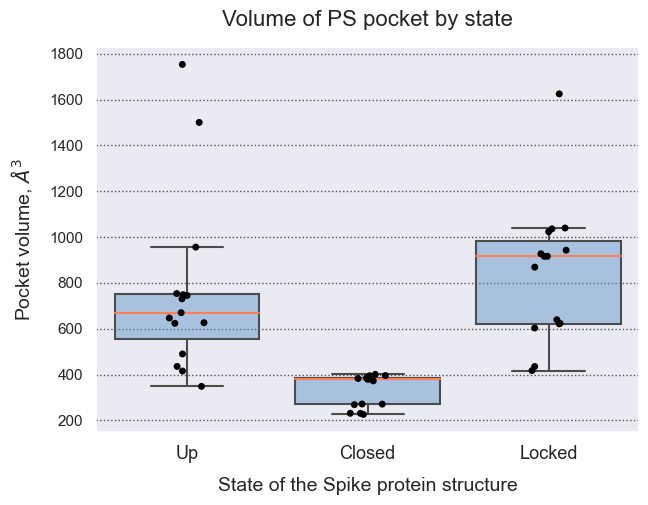

In [38]:
Vol_ResidueBarPlot(pocket_volume_df,
                   pocket_contact_df,
                   PS_residues,
                   "Volume of PS pocket by state")

# plt.savefig('PS_pocket_vol_barplot.png', dpi=300, bbox_inches='tight')
plt.show()

In [39]:
# manually curated IDs of the pockets for each chain in each structure 
pockets_PS = np.array([134, 133, 141, 209, 172, 207, 126, 124, 83, 0, 71, 149, 164, 184, 204,
                       110, 71, 117, 64, 86, 39, 198, 175, 204, 137, 157, 156, 95, 96, 121,
                       0, 0, 0, 38, 152, 166, 52, 138, 148, 87, 150, 194, 200, 196, 173])

sns.set_style("darkgrid", {"grid.color": ".3", 
                           "grid.linestyle": ":"})

plt.figure(figsize=(7, 5))
    
# get volumes 
volumes = []
for i, pocket_id in enumerate(pockets_PS):
    if pocket_id == 0:
        volumes.append(0)
    else:
        row_data = pocket_volume_df.iloc[i, :].values
        try:
            volumes.append(row_data[pocket_contact_df.iloc[i, :].values == pocket_id][0])
        except:
            print(i, pocket_id)
volumes=np.array(volumes).reshape((3,-1))
    
ax = sns.scatterplot(x = volumes[0], y = PSpocket_data[0], label='Up', s=60, alpha=0.8)
sns.scatterplot(x = volumes[1], y = PSpocket_data[1], label='Closed', s=60, alpha=0.8)
sns.scatterplot(x = volumes[2], y = PSpocket_data[2], label='Locked', s=60, alpha=0.8)

ax.legend(fontsize=15)
ax.tick_params(axis='y', labelsize=11)
ax.tick_params(axis='x', labelsize=11)
ax.set_title("Average Pocket Miner probability of PS pocket residues \nvs. pocket valume by Spike state",
             fontsize = 16, pad=15)
ax.set_ylabel("Average Pocket Miner probability of pcoket residues",
              fontsize = 14, labelpad=10)
ax.set_xlabel("Estimated pocket volume, $Å^3$",
              fontsize = 14, labelpad=10)

# plt.savefig('PS_pob_vs_vol_ajusted.png', dpi=300, bbox_inches='tight')
plt.show()

In [43]:
# save data for ANCOVA analysis in R

data_for_R = pd.DataFrame(data= list(zip(
                                        ['up']*15 + ['closed']*15 + ['locked']*15,
                                        PSpocket_data.reshape((1, -1))[0],
                                        volumes.reshape((1, -1))[0],
                                        )),
                          columns =['state', 'probability', 'volume'])

data_for_R.to_csv('data/PS_probabilities_vs_volume.csv', index=False)   

## How many residues with high probabilities have we explained?

In [40]:
residues_to_leave = [i for i in range(962, 1025)] + [i for i in range(1146, 1167)] + \
                    [i for i in range(1187, 1197)] + \
                    [i for i in range(870, 917)] + \
                    [i for i in range(553, 575)] + \
                    [i for i in range(662, 673)] + \
                    [i for i in range(291, 306)] + \
                    [i for i in range(626, 637)]

# if specified like this we only take the residues contacting the pocket ligands etc missing others
# explained_residues = set(residues_to_leave + \
#                      [el[0] for el in MM_residues] + \
#                      [el[0] for el in LA_residues] + \
#                      [el[0] for el in PS_residues])

# here we completely include RBD and NTD   
explained_residues = set(residues_to_leave + [el[0] for el in MM_residues] + [i for i in range(14, 306)] + [i for i in range(319, 542)]) #  NTD and RBD

# we better exclude these
stem_residues = ['1163', '1164', '1165', '1166', '1187', '1188', '1189', '1190',
                 '1191', '1192', '1193', '1194', '1195', '1196']

explained_residues = [str(res) for res in explained_residues if not str(res) in stem_residues]

print(f"Selected {len(explained_residues)} residues with explained pocket/conformational mobility")

Selected 718 residues with explained pocket/conformational mobility


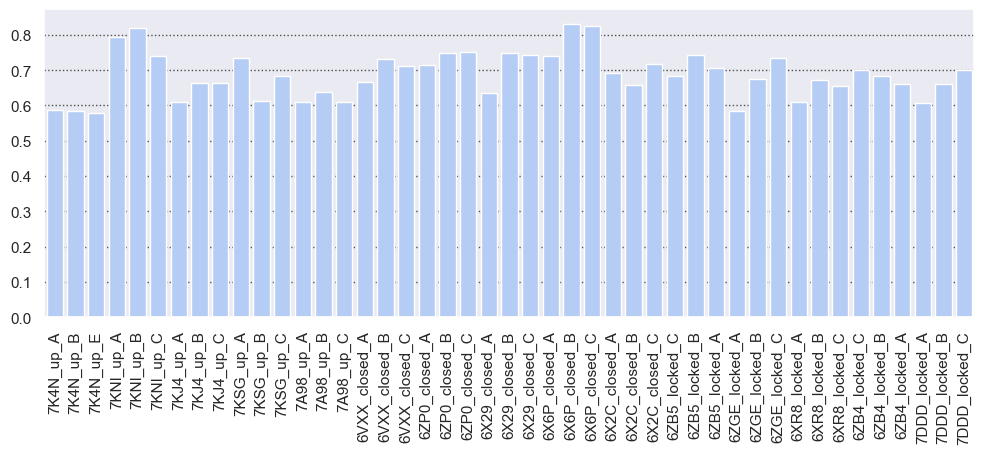

In [41]:
threshold = 0.8

explained_data = []
for structure in PocketMiner_df.index:
    
    n_exp = np.sum(PocketMiner_df.loc[structure, explained_residues].values > threshold)
    n_all = np.sum(PocketMiner_df.loc[structure, :].values > threshold)
    
    explained_data.append(n_exp / n_all)
    
plt.figure(figsize=(12, 4))
ax = sns.barplot(x = PocketMiner_df.index,
                 y = explained_data,
                 color = '#abcbff')
ax.set_xticklabels(list(PocketMiner_df.index), rotation=90)
plt.show()

In [42]:
# 58-83% of the high probability residues 
print(np.array(explained_data).reshape((3, -1)).max(axis=1))
print(np.array(explained_data).reshape((3, -1)).min(axis=1))

[0.82089552 0.8317757  0.74172185]
[0.57894737 0.63461538 0.58433735]
